# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from scipy.stats import randint, uniform
from collections import Counter
from itertools import product
import json
import onnx
import onnxruntime as ort
import yaml

from IPython.display import Image
from core.mixer import Mixer
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from core.utils import *

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import resample


import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.cuda.amp import autocast, GradScaler 
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Train data

In [31]:
cancer_sample_annot = pd.read_csv('data/cancer_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cancer_expr = pd.read_csv('data/cancer_expr.tsv.tar.gz', sep='\t', index_col=0)
cells_sample_annot = pd.read_csv('data/cells_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cells_expr = pd.read_csv('data/cells_expr.tsv.tar.gz', sep='\t', index_col=0)


filtered_cancer_sample_annot = cancer_sample_annot.drop('SRX2880123')
filtered_cancer_expr = cancer_expr.drop(columns=['SRX2880123'])

stratify_column = 'Tumor_type'  
test_size = 0.5  

train_cancer_sample_annot, test_cancer_sample_annot = train_test_split(
    filtered_cancer_sample_annot,
    test_size=test_size,
    stratify=filtered_cancer_sample_annot[stratify_column],
    random_state=42
)

test_cancer_sample_annot = pd.concat([test_cancer_sample_annot, cancer_sample_annot.loc[['SRX2880123']]], axis=0)
train_samples = train_cancer_sample_annot['Sample'].values
test_samples = test_cancer_sample_annot['Sample'].values

train_cancer_expr = cancer_expr.loc[:, list(train_samples)]
test_cancer_expr = cancer_expr.loc[:, list(test_samples)]

stratify_column = 'Cell_type'
test_size = 0.5  

train_cells_sample_annot, test_cells_sample_annot = train_test_split(
    cells_sample_annot,
    test_size=test_size,
    stratify=cells_sample_annot[stratify_column],
    random_state=42
)

train_cells_samples = train_cells_sample_annot['Sample'].values
test_cells_samples = test_cells_sample_annot['Sample'].values

train_cells_expr = cells_expr.loc[:, list(train_cells_samples)]
test_cells_expr = cells_expr.loc[:, list(test_cells_samples)]

cell_types = CellTypes.load('configs/cell_types.yaml')

In [32]:
mixer_train = Mixer(cell_types=cell_types,
              cells_expr=train_cells_expr, cells_annot=train_cells_sample_annot,
              tumor_expr=train_cancer_expr, tumor_annot=train_cancer_sample_annot,
              num_points=100000, num_av=3)
mixer_test = Mixer(cell_types=cell_types,
              cells_expr=test_cells_expr, cells_annot=test_cells_sample_annot,
              tumor_expr=test_cancer_expr, tumor_annot=test_cancer_sample_annot,
              num_points=100, num_av=3)

def renorm_expressions(expr, genes_in_expressions_file):
    genes_in_expressions = []
    with open(genes_in_expressions_file, 'r') as file:
        for line in file:
            gene = line[:-1]
            genes_in_expressions.append(gene)
    genes = list(set(expr.index) & set(genes_in_expressions))
    renormed_expr = expr.loc[genes].div(expr.loc[genes].sum(axis=0), axis='columns') * 1e6
    return renormed_expr


genes_in_expression_file = './data/genes_in_expression.txt'

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK


# Models

## ConvNeXt model

In [33]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output


class ConvNeXt1DBlock(nn.Module):
    def __init__(self, dim, drop_path=0.1, layer_scale_init_value=1e-6, dropout_rate=0.1):
        super().__init__()


        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate) 
        self.pwconv2 = nn.Linear(4 * dim, dim) 

        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim)) if layer_scale_init_value > 0 else None

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)  
        x = x.permute(0, 2, 1) 
        x = self.norm(x) 
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.dropout(x)  
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 2, 1)  
        x = input + self.drop_path(x)
        return x


class ConvNeXt1DForProportions(nn.Module):
    def __init__(self, in_channels=1, num_cells=4, depths=[3, 3, 6], dims=[128, 256, 512]):
        super().__init__()

 
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, dims[0], kernel_size=4, stride=4),  
            nn.BatchNorm1d(dims[0])  
        )

        self.stages = nn.ModuleList()
        for i in range(len(depths)):
            stage = nn.Sequential(
                *[ConvNeXt1DBlock(dim=dims[i], dropout_rate=0.1) for _ in range(depths[i])]
            )
            self.stages.append(stage)

        self.downsamples = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(dims[i], dims[i+1], kernel_size=2, stride=2), 
                nn.BatchNorm1d(dims[i+1])
            ) for i in range(len(dims)-1)
        ])


        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), 
            nn.Flatten(),
            nn.LayerNorm(dims[-1], eps=1e-6),
            nn.Linear(dims[-1], num_cells),
            nn.Softmax(dim=-1) 
        )

    def forward(self, x):
        x = self.stem(x)

        for i in range(len(self.stages)):
            x = self.stages[i](x)
            if i < len(self.downsamples):
                x = self.downsamples[i](x)

        x = self.head(x)
        return x

def init_weights(m):
    """
    Custom weight initialization function.
    - Kaiming Normal initialization for Conv1d layers.
    - Xavier Normal initialization for Linear layers.
    """
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Transformer model

In [6]:
class TransDeconv(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead, num_layers, latent_dim, output_dim):
        super(TransDeconv, self).__init__()
        
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.embedding_dropout = nn.Dropout(p=0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.transformer_dropout = nn.Dropout(p=0.1)
        
        

        self.fc_latent = nn.Linear(hidden_dim, latent_dim)
        self.latent_norm = nn.LayerNorm(latent_dim)
        self.latent_dropout = nn.Dropout(p=0.2)
        self.fc_output = nn.Linear(latent_dim, output_dim)

        self._initialize_weights()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = self.layer_norm(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = self.transformer_dropout(x)
        x = x.squeeze(1)
        x = self.fc_latent(x)
        x = self.latent_norm(x)
        x = self.latent_dropout(x)
        x = self.fc_output(x)  
        x = F.log_softmax(x, dim=1)  
        return x
    
    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        if self.embedding.bias is not None:
            nn.init.constant_(self.embedding.bias, 0)
        
        nn.init.xavier_uniform_(self.fc_latent.weight)
        if self.fc_latent.bias is not None:
            nn.init.constant_(self.fc_latent.bias, 0)
        
        nn.init.xavier_uniform_(self.fc_output.weight)
        if self.fc_output.bias is not None:
            nn.init.constant_(self.fc_output.bias, 0)

# Training

## ConvNeXt

In [34]:
cells = cell_types.names[:6].copy() + cell_types.names[7:].copy()

In [35]:
cells

['B_cells',
 'CD4_T_cells',
 'CD8_T_cells',
 'Dendritic_cells',
 'Endothelium',
 'Fibroblasts',
 'Granulocytes',
 'Immune_general',
 'Macrophages',
 'Monocytes',
 'Monocytic_cells',
 'NK_cells',
 'Non_plasma_B_cells',
 'Plasma_B_cells',
 'T_cells']

In [21]:
#cells_for_convnext = [cells[7], cells[0], cells[12]]
#ниже надо сделать цикл для обучения трех моделей, for cell in cells_for_convnext
# selected_cell = cell
# Тут этого не сделано, потому что займет очень много времени, надо запускать на отдельном сервере, даже с батчем 1024
# идет долго

In [40]:
selected_cell = 'B_cells'
selected_genes = cell_types[selected_cell].genes.copy()
if selected_cell != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
expr_train, values_train = mixer_train.generate(selected_cell, genes=selected_genes, random_seed=17)


data = expr_train
targets = values_train 
input_size=data.shape[1]

data = renorm_expressions(data, genes_in_expression_file)


X = torch.tensor(data.T.values, dtype=torch.float32)
y = torch.tensor(targets.T.values, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TensorDataset(X, y)

criterion = nn.KLDivLoss(reduction='batchmean', log_target=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def init_weights(m):
    """
    Custom weight initialization function.
    - Kaiming Normal initialization for Conv1d layers.
    - Xavier Normal initialization for Linear layers.
    """
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def train_ConvNeXt(dataset, num_epochs=100, n_splits=5, batch_size=32):
    
    X, y = zip(*[(x, y) for x, y in dataset])  
    X = torch.stack(X)  
    y = torch.stack(y)  


    dominant_classes = y.argmax(dim=1).numpy()  


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    best_val_loss_across_folds = float('inf')
    best_model_path = 'best_ConvNeXt.pth'


    all_train_losses = []
    all_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, dominant_classes)):
        print(f"\nFold {fold + 1}/{n_splits}")
        

        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ConvNeXt1DForProportions(num_cells=values_train.shape[0]).to(device)
        model.apply(init_weights)  
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        best_val_loss = float('inf')
        patience = 5
        trigger_times = 0
        

        train_losses = []
        val_losses = []


        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()


            train_loss = 0
            for batch in train_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                
                inputs = inputs.unsqueeze(1)  # (batch_size, 1, num_features)

                # Forward pass
                outputs = model(inputs)
                outputs = torch.log(outputs + 1e-9)  # Log-probabilities for KLDivLoss
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            val_loss = validate_model(model, val_loader)
            val_losses.append(val_loss)

            end_time = time.time()
            epoch_time = end_time - start_time

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} s")

            # Step the LR scheduler based on validation loss
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping!")
                    break

        # Store losses for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Check if this fold's best validation loss is the best across all folds
        if best_val_loss < best_val_loss_across_folds:
            best_val_loss_across_folds = best_val_loss
            torch.save(model.state_dict(), best_model_path)  # Save the best model across all folds
            print(f"New best model saved with Val Loss: {best_val_loss_across_folds:.4f}")

        # Plot results for this fold
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {fold + 1} - Training and Validation Loss")
        plt.legend()
        plt.show()

    # Aggregate results across folds
    max_epochs = max(len(fold_losses) for fold_losses in all_train_losses)
    avg_train_losses = [sum([fold_losses[epoch] for fold_losses in all_train_losses if epoch < len(fold_losses)]) / n_splits for epoch in range(max_epochs)]
    avg_val_losses = [sum([fold_losses[epoch] for fold_losses in all_val_losses if epoch < len(fold_losses)]) / n_splits for epoch in range(max_epochs)]

    # Plot aggregated results
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_losses, label="Average Train Loss")
    plt.plot(avg_val_losses, label="Average Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Aggregated Training and Validation Loss Across Folds")
    plt.legend()
    plt.show()

    print(f"\nBest model across all folds saved at '{best_model_path}' with Val Loss: {best_val_loss_across_folds:.4f}")


def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Add channel dimension for Conv1d
            inputs = inputs.unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            outputs = torch.log(outputs + 1e-9)  # Log-probabilities for KLDivLoss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss


Fold 1/5
Epoch [1/100], Train Loss: 1.3707, Val Loss: 1.0640, Time: 13.94 s
Epoch [2/100], Train Loss: 0.9415, Val Loss: 0.8012, Time: 13.59 s
Epoch [3/100], Train Loss: 0.6830, Val Loss: 0.5644, Time: 13.61 s
Epoch [4/100], Train Loss: 0.5011, Val Loss: 0.4544, Time: 13.75 s
Epoch [5/100], Train Loss: 0.4417, Val Loss: 0.4222, Time: 13.68 s
Epoch [6/100], Train Loss: 0.4191, Val Loss: 0.4040, Time: 13.68 s
Epoch [7/100], Train Loss: 0.4027, Val Loss: 0.3892, Time: 13.81 s
Epoch [8/100], Train Loss: 0.3896, Val Loss: 0.3743, Time: 13.70 s
Epoch [9/100], Train Loss: 0.3772, Val Loss: 0.3620, Time: 13.72 s
Epoch [10/100], Train Loss: 0.3653, Val Loss: 0.3503, Time: 13.84 s
Epoch [11/100], Train Loss: 0.3560, Val Loss: 0.3393, Time: 13.73 s
Epoch [12/100], Train Loss: 0.3473, Val Loss: 0.3318, Time: 13.74 s
Epoch [13/100], Train Loss: 0.3392, Val Loss: 0.3231, Time: 13.86 s
Epoch [14/100], Train Loss: 0.3321, Val Loss: 0.3159, Time: 13.78 s
Epoch [15/100], Train Loss: 0.3270, Val Loss: 0

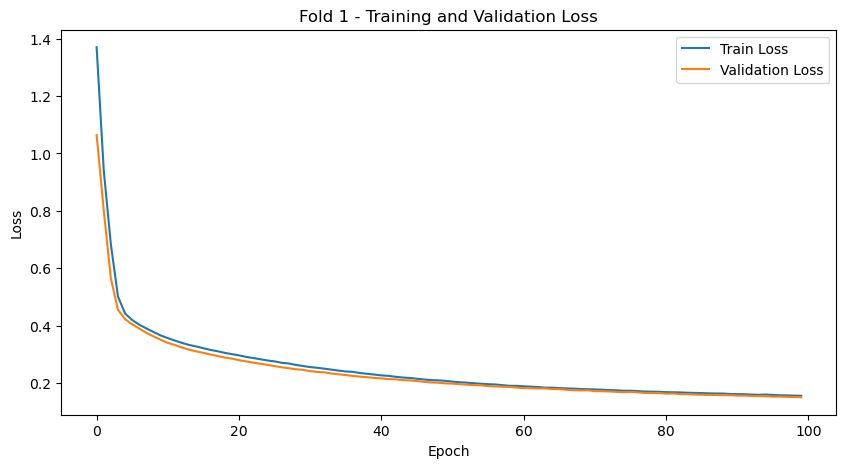


Fold 2/5
Epoch [1/100], Train Loss: 1.4299, Val Loss: 1.1375, Time: 13.83 s
Epoch [2/100], Train Loss: 0.9564, Val Loss: 0.8386, Time: 13.84 s
Epoch [3/100], Train Loss: 0.6879, Val Loss: 0.5806, Time: 13.95 s
Epoch [4/100], Train Loss: 0.5124, Val Loss: 0.4633, Time: 13.84 s
Epoch [5/100], Train Loss: 0.4531, Val Loss: 0.4278, Time: 13.84 s
Epoch [6/100], Train Loss: 0.4286, Val Loss: 0.4085, Time: 13.95 s
Epoch [7/100], Train Loss: 0.4114, Val Loss: 0.3939, Time: 13.85 s
Epoch [8/100], Train Loss: 0.3976, Val Loss: 0.3773, Time: 13.84 s
Epoch [9/100], Train Loss: 0.3833, Val Loss: 0.3628, Time: 13.96 s
Epoch [10/100], Train Loss: 0.3698, Val Loss: 0.3504, Time: 13.84 s
Epoch [11/100], Train Loss: 0.3607, Val Loss: 0.3398, Time: 13.85 s
Epoch [12/100], Train Loss: 0.3509, Val Loss: 0.3318, Time: 13.96 s
Epoch [13/100], Train Loss: 0.3429, Val Loss: 0.3230, Time: 13.84 s
Epoch [14/100], Train Loss: 0.3350, Val Loss: 0.3162, Time: 13.84 s
Epoch [15/100], Train Loss: 0.3289, Val Loss: 0

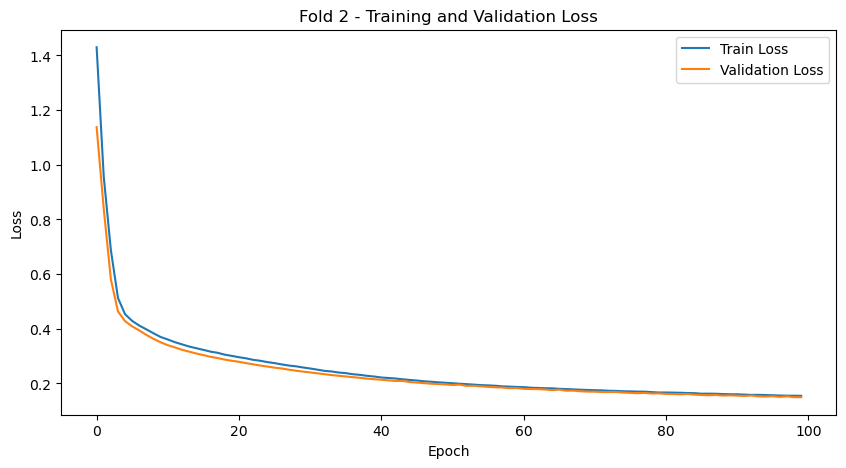


Fold 3/5
Epoch [1/100], Train Loss: 1.4245, Val Loss: 1.1174, Time: 13.85 s
Epoch [2/100], Train Loss: 0.9461, Val Loss: 0.8205, Time: 13.97 s
Epoch [3/100], Train Loss: 0.6771, Val Loss: 0.5702, Time: 13.85 s
Epoch [4/100], Train Loss: 0.5006, Val Loss: 0.4593, Time: 13.85 s
Epoch [5/100], Train Loss: 0.4463, Val Loss: 0.4269, Time: 13.95 s
Epoch [6/100], Train Loss: 0.4238, Val Loss: 0.4060, Time: 13.84 s
Epoch [7/100], Train Loss: 0.4082, Val Loss: 0.3911, Time: 13.84 s
Epoch [8/100], Train Loss: 0.3944, Val Loss: 0.3756, Time: 13.96 s
Epoch [9/100], Train Loss: 0.3802, Val Loss: 0.3614, Time: 13.85 s
Epoch [10/100], Train Loss: 0.3694, Val Loss: 0.3520, Time: 13.84 s
Epoch [11/100], Train Loss: 0.3598, Val Loss: 0.3408, Time: 13.96 s
Epoch [12/100], Train Loss: 0.3522, Val Loss: 0.3323, Time: 13.84 s
Epoch [13/100], Train Loss: 0.3453, Val Loss: 0.3252, Time: 13.84 s
Epoch [14/100], Train Loss: 0.3375, Val Loss: 0.3194, Time: 13.95 s
Epoch [15/100], Train Loss: 0.3326, Val Loss: 0

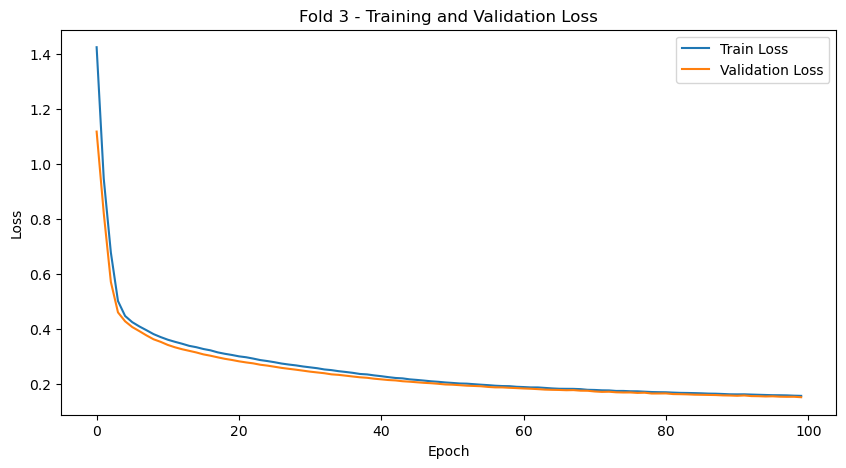


Fold 4/5
Epoch [1/100], Train Loss: 1.5929, Val Loss: 1.1711, Time: 13.95 s
Epoch [2/100], Train Loss: 0.9872, Val Loss: 0.8147, Time: 13.83 s
Epoch [3/100], Train Loss: 0.6971, Val Loss: 0.5723, Time: 13.83 s
Epoch [4/100], Train Loss: 0.5121, Val Loss: 0.4634, Time: 13.95 s
Epoch [5/100], Train Loss: 0.4519, Val Loss: 0.4316, Time: 13.85 s
Epoch [6/100], Train Loss: 0.4292, Val Loss: 0.4109, Time: 13.85 s
Epoch [7/100], Train Loss: 0.4124, Val Loss: 0.3952, Time: 13.95 s
Epoch [8/100], Train Loss: 0.3980, Val Loss: 0.3803, Time: 13.84 s
Epoch [9/100], Train Loss: 0.3841, Val Loss: 0.3656, Time: 13.84 s
Epoch [10/100], Train Loss: 0.3707, Val Loss: 0.3539, Time: 13.95 s
Epoch [11/100], Train Loss: 0.3606, Val Loss: 0.3426, Time: 13.84 s
Epoch [12/100], Train Loss: 0.3514, Val Loss: 0.3338, Time: 13.83 s
Epoch [13/100], Train Loss: 0.3448, Val Loss: 0.3251, Time: 13.95 s
Epoch [14/100], Train Loss: 0.3372, Val Loss: 0.3182, Time: 13.84 s
Epoch [15/100], Train Loss: 0.3307, Val Loss: 0

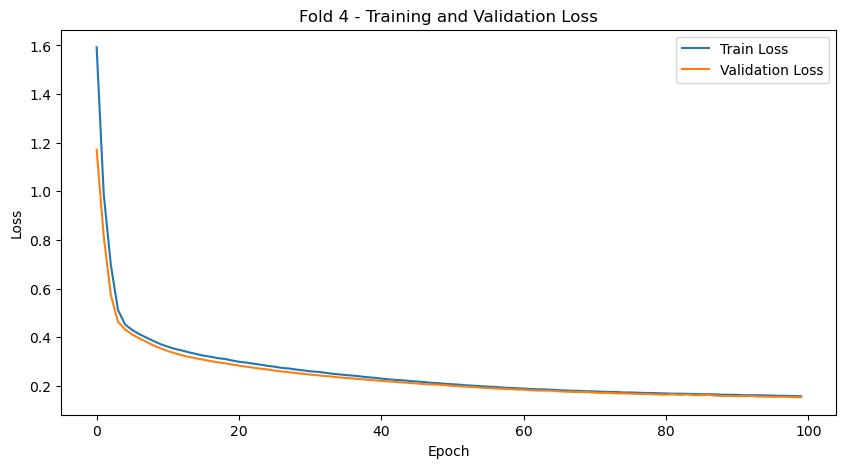


Fold 5/5
Epoch [1/100], Train Loss: 1.3466, Val Loss: 1.0524, Time: 13.82 s
Epoch [2/100], Train Loss: 0.9204, Val Loss: 0.7924, Time: 13.81 s
Epoch [3/100], Train Loss: 0.6754, Val Loss: 0.5542, Time: 13.92 s
Epoch [4/100], Train Loss: 0.5030, Val Loss: 0.4558, Time: 13.82 s
Epoch [5/100], Train Loss: 0.4484, Val Loss: 0.4228, Time: 13.81 s
Epoch [6/100], Train Loss: 0.4247, Val Loss: 0.4065, Time: 13.93 s
Epoch [7/100], Train Loss: 0.4097, Val Loss: 0.3889, Time: 13.81 s
Epoch [8/100], Train Loss: 0.3959, Val Loss: 0.3755, Time: 13.81 s
Epoch [9/100], Train Loss: 0.3823, Val Loss: 0.3618, Time: 13.92 s
Epoch [10/100], Train Loss: 0.3709, Val Loss: 0.3510, Time: 13.81 s
Epoch [11/100], Train Loss: 0.3604, Val Loss: 0.3411, Time: 13.81 s
Epoch [12/100], Train Loss: 0.3523, Val Loss: 0.3327, Time: 13.92 s
Epoch [13/100], Train Loss: 0.3443, Val Loss: 0.3247, Time: 13.82 s
Epoch [14/100], Train Loss: 0.3366, Val Loss: 0.3173, Time: 13.81 s
Epoch [15/100], Train Loss: 0.3302, Val Loss: 0

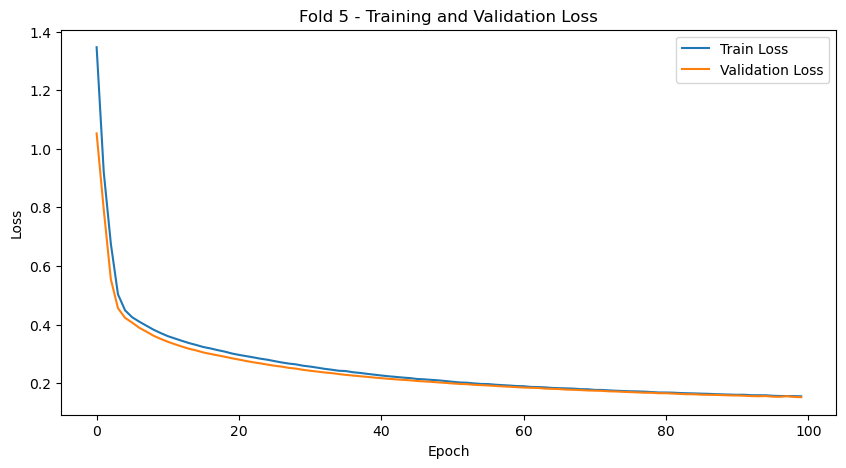

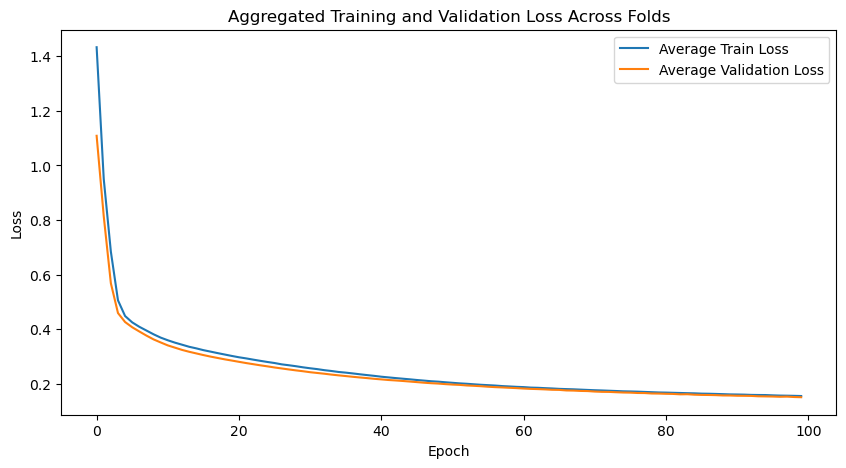


Best model across all folds saved at 'best_ConvNeXt.pth' with Val Loss: 0.1495


In [41]:
train_ConvNeXt(dataset, batch_size=2048)

## Transformers

In [86]:
def load_json_data(selected_cell):
    file_name = f"./transformers/grid_search_results_{selected_cell}.json"
    
    try:
        with open(file_name, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Файл {file_name} не найден.")
        return None
    except json.JSONDecodeError:
        print(f"Ошибка при декодировании JSON в файле {file_name}.")
        return None

def load_model_params(selected_cell, default_params=None):
    if default_params is None:
        default_params = {
            "hidden_dim": 32,
            "nhead": 1,
            "num_layers": 1,
            "latent_dim": 16,
            "lr": 3e-4,
            "weight_decay": 0.01
        }

    file_name = f"./transformers/grid_search_results_{selected_cell}.json"

    try:
        with open(file_name, 'r') as f:
            data = json.load(f)

       
        if selected_cell in data:
            best_params = data[selected_cell]["best_params"]
            params = {k: best_params.get(k, v) for k, v in default_params.items()}

            print(f"[INFO] Параметры успешно загружены из {file_name}")
            return params
        else:
            print(f"[WARNING] Ячейка '{selected_cell}' не найдена в JSON. Используются значения по умолчанию.")
            return default_params

    except FileNotFoundError:
        print(f"[ERROR] Файл {file_name} не найден. Используются значения по умолчанию.")
        return default_params
    except json.JSONDecodeError:
        print(f"[ERROR] Ошибка чтения JSON в файле {file_name}. Используются значения по умолчанию.")
        return default_params
    except Exception as e:
        print(f"[ERROR] Произошла ошибка: {e}. Используются значения по умолчанию.")
        return default_params

[INFO] Параметры успешно загружены из ./transformers/grid_search_results_B_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.3647
Validation Loss for Epoch 1: 0.1764
Saved best overall model with Validation Loss: 0.1764
Epoch [2/100], Train Loss: 0.1950
Validation Loss for Epoch 2: 0.1441
Saved best overall model with Validation Loss: 0.1441
Epoch [3/100], Train Loss: 0.1610
Validation Loss for Epoch 3: 0.1351
Saved best overall model with Validation Loss: 0.1351
Epoch [4/100], Train Loss: 0.1444
Validation Loss for Epoch 4: 0.1202
Saved best overall model with Validation Loss: 0.1202
Epoch [5/100], Train Loss: 0.1310
Validation Loss for Epoch 5: 0.1120
Saved best overall model with Validation Loss: 0.1120
Epoch [6/100], Train Loss: 0.1226
Validation Loss for Epoch 6: 0.1096
Saved best overall model with Validation Loss: 0.1096
Epoch [7/100], Train Loss: 0.1154
Validation Loss for Epoch 7: 0.1014
Saved best overall model with Validation Loss: 0.1014
Epoch [8/100], Train Loss: 0.1094
Validation Loss for Epoch 8: 0.0929
Saved best overall model with Validation Loss: 0.0929
Epoch [9

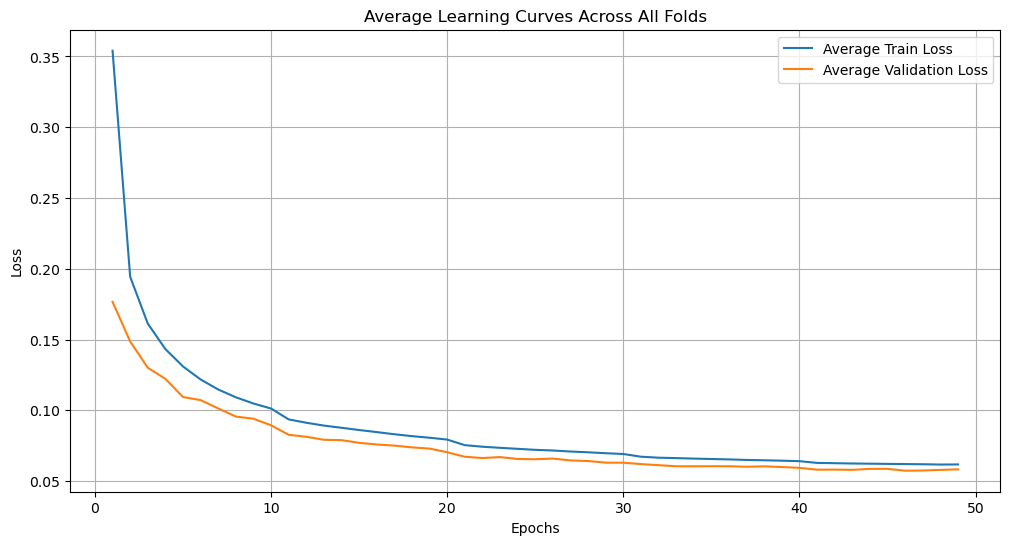

Average Validation Loss across all folds: 0.0603
время на один тип клеток: 236.1541383266449
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_CD4_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2557
Validation Loss for Epoch 1: 0.1413
Saved best overall model with Validation Loss: 0.1413
Epoch [2/100], Train Loss: 0.1533
Validation Loss for Epoch 2: 0.1126
Saved best overall model with Validation Loss: 0.1126
Epoch [3/100], Train Loss: 0.1333
Validation Loss for Epoch 3: 0.1081
Saved best overall model with Validation Loss: 0.1081
Epoch [4/100], Train Loss: 0.1229
Validation Loss for Epoch 4: 0.0991
Saved best overall model with Validation Loss: 0.0991
Epoch [5/100], Train Loss: 0.1144
Validation Loss for Epoch 5: 0.0940
Saved best overall model with Validation Loss: 0.0940
Epoch [6/100], Train Loss: 0.1081
Validation Loss for Epoch 6: 0.0876
Saved best overall model with Validation Loss: 0.0876
Epoch [7/100], Train Loss: 0.1027
Validation Loss for Epoch 7: 0

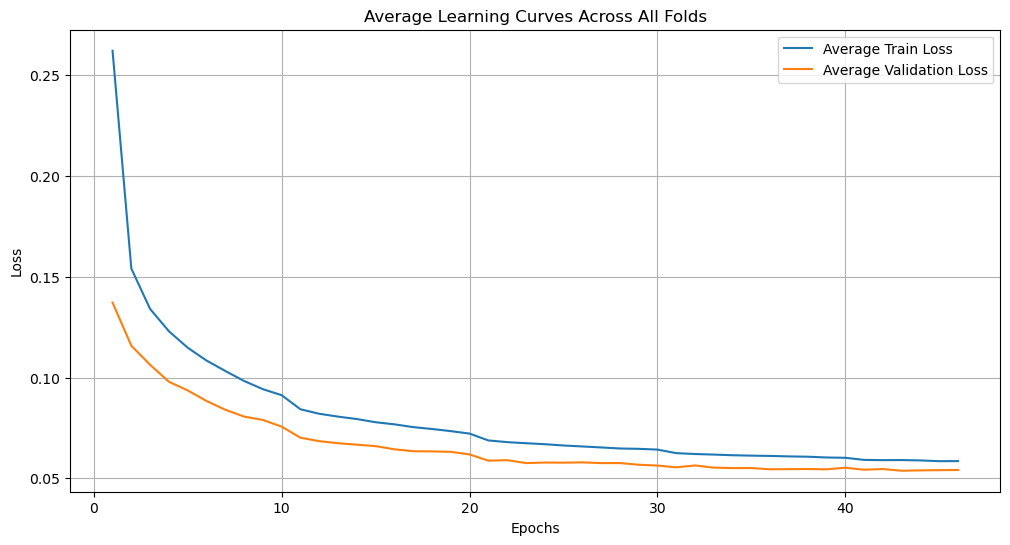

Average Validation Loss across all folds: 0.0562
время на один тип клеток: 189.07517504692078
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_CD8_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3136
Validation Loss for Epoch 1: 0.1657
Saved best overall model with Validation Loss: 0.1657
Epoch [2/100], Train Loss: 0.1964
Validation Loss for Epoch 2: 0.1331
Saved best overall model with Validation Loss: 0.1331
Epoch [3/100], Train Loss: 0.1667
Validation Loss for Epoch 3: 0.1194
Saved best overall model with Validation Loss: 0.1194
Epoch [4/100], Train Loss: 0.1512
Validation Loss for Epoch 4: 0.1158
Saved best overall model with Validation Loss: 0.1158
Epoch [5/100], Train Loss: 0.1405
Validation Loss for Epoch 5: 0.1133
Saved best overall model with Validation Loss: 0.1133
Epoch [6/100], Train Loss: 0.1321
Validation Loss for Epoch 6: 0.1016
Saved best overall model with Validation Loss: 0.1016
Epoch [7/100], Train Loss: 0.1258
Validation Loss for Epoch 7: 

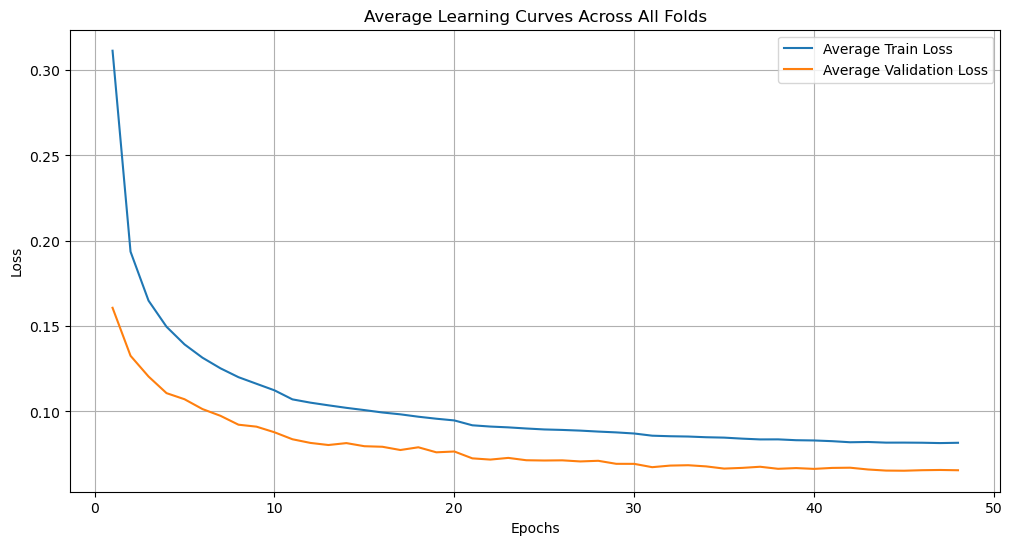

Average Validation Loss across all folds: 0.0699
время на один тип клеток: 232.96277332305908
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Dendritic_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2693
Validation Loss for Epoch 1: 0.1357
Saved best overall model with Validation Loss: 0.1357
Epoch [2/100], Train Loss: 0.1565
Validation Loss for Epoch 2: 0.1211
Saved best overall model with Validation Loss: 0.1211
Epoch [3/100], Train Loss: 0.1352
Validation Loss for Epoch 3: 0.1114
Saved best overall model with Validation Loss: 0.1114
Epoch [4/100], Train Loss: 0.1241
Validation Loss for Epoch 4: 0.0956
Saved best overall model with Validation Loss: 0.0956
Epoch [5/100], Train Loss: 0.1163
Validation Loss for Epoch 5: 0.0925
Saved best overall model with Validation Loss: 0.0925
Epoch [6/100], Train Loss: 0.1102
Validation Loss for Epoch 6: 0.0869
Saved best overall model with Validation Loss: 0.0869
Epoch [7/100], Train Loss: 0.1055
Validation Loss for Epoch

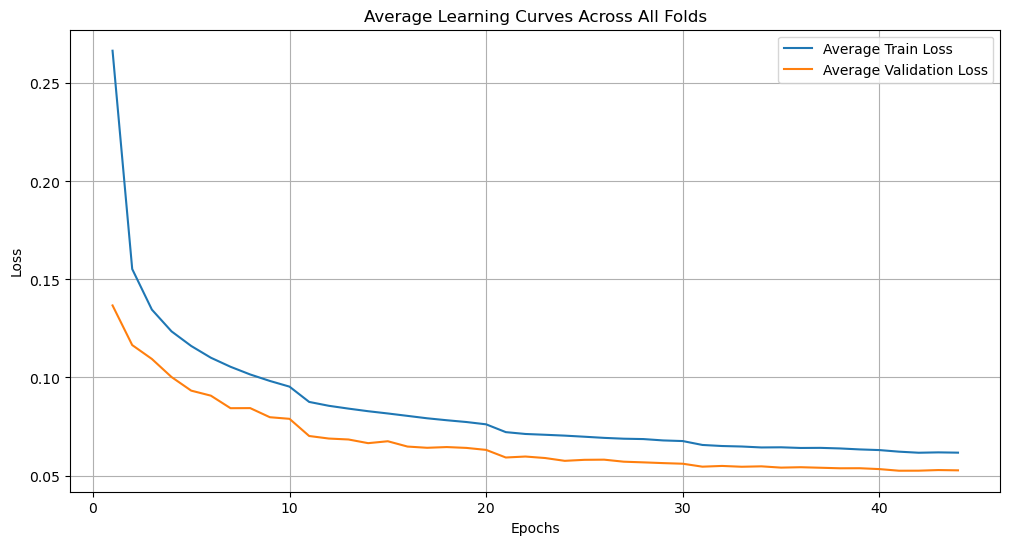

Average Validation Loss across all folds: 0.0575
время на один тип клеток: 160.37338852882385
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Endothelium.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.1614
Validation Loss for Epoch 1: 0.0878
Saved best overall model with Validation Loss: 0.0878
Epoch [2/100], Train Loss: 0.0972
Validation Loss for Epoch 2: 0.0682
Saved best overall model with Validation Loss: 0.0682
Epoch [3/100], Train Loss: 0.0832
Validation Loss for Epoch 3: 0.0612
Saved best overall model with Validation Loss: 0.0612
Epoch [4/100], Train Loss: 0.0759
Validation Loss for Epoch 4: 0.0556
Saved best overall model with Validation Loss: 0.0556
Epoch [5/100], Train Loss: 0.0703
Validation Loss for Epoch 5: 0.0541
Saved best overall model with Validation Loss: 0.0541
Epoch [6/100], Train Loss: 0.0665
Validation Loss for Epoch 6: 0.0487
Saved best overall model with Validation Loss: 0.0487
Epoch [7/100], Train Loss: 0.0636
Validation Loss for Epoch 7: 0.0469
Saved best overall model with Validation Loss: 0.0469
Epoch [8/100], Train Loss: 0.0606
Validation Loss for Epoch 8: 0.0453
Saved best overall model with Validation Loss: 0.0453
Epoch [9

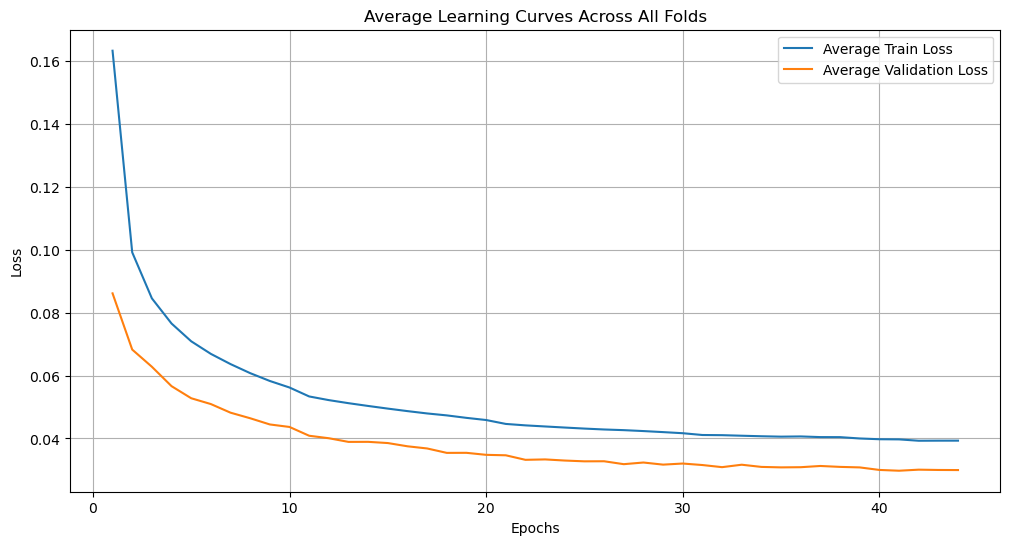

Average Validation Loss across all folds: 0.0308
время на один тип клеток: 197.83067560195923
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Fibroblasts.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.1502
Validation Loss for Epoch 1: 0.0499
Saved best overall model with Validation Loss: 0.0499
Epoch [2/100], Train Loss: 0.0556
Validation Loss for Epoch 2: 0.0374
Saved best overall model with Validation Loss: 0.0374
Epoch [3/100], Train Loss: 0.0450
Validation Loss for Epoch 3: 0.0454
Epoch [4/100], Train Loss: 0.0398
Validation Loss for Epoch 4: 0.0361
Saved best overall model with Validation Loss: 0.0361
Epoch [5/100], Train Loss: 0.0358
Validation Loss for Epoch 5: 0.0316
Saved best overall model with Validation Loss: 0.0316
Epoch [6/100], Train Loss: 0.0335
Validation Loss for Epoch 6: 0.0272
Saved best overall model with Validation Loss: 0.0272
Epoch [7/100], Train Loss: 0.0311
Validation Loss for Epoch 7: 0.0243
Saved best overall model with Validation Loss: 0.0243
Epoch [8/100], Train Loss: 0.0292
Validation Loss for Epoch 8: 0.0223
Saved best overall model with Validation Loss: 0.0223
Epoch [9/100], Train Loss: 0.0281
Validation Loss for Epoch 9:

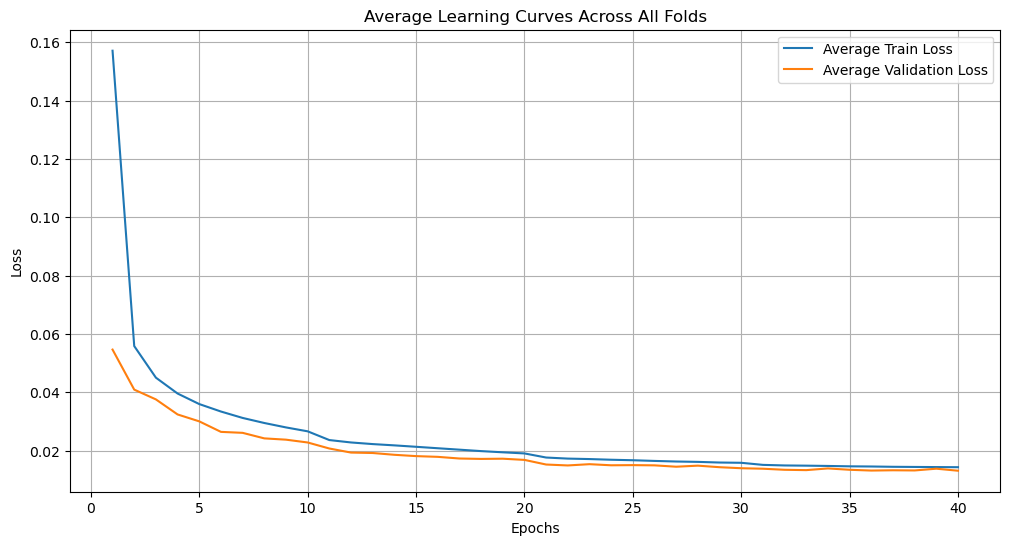

Average Validation Loss across all folds: 0.0144
время на один тип клеток: 184.5746419429779
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Granulocytes.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3314
Validation Loss for Epoch 1: 0.1472
Saved best overall model with Validation Loss: 0.1472
Epoch [2/100], Train Loss: 0.1621
Validation Loss for Epoch 2: 0.1226
Saved best overall model with Validation Loss: 0.1226
Epoch [3/100], Train Loss: 0.1370
Validation Loss for Epoch 3: 0.1130
Saved best overall model with Validation Loss: 0.1130
Epoch [4/100], Train Loss: 0.1260
Validation Loss for Epoch 4: 0.1272
Epoch [5/100], Train Loss: 0.1165
Validation Loss for Epoch 5: 0.0974
Saved best overall model with Validation Loss: 0.0974
Epoch [6/100], Train Loss: 0.1092
Validation Loss for Epoch 6: 0.0955
Saved best overall model with Validation Loss: 0.0955
Epoch [7/100], Train Loss: 0.1037
Validation Loss for Epoch 7: 0.0872
Saved best overall model with Validation Loss: 

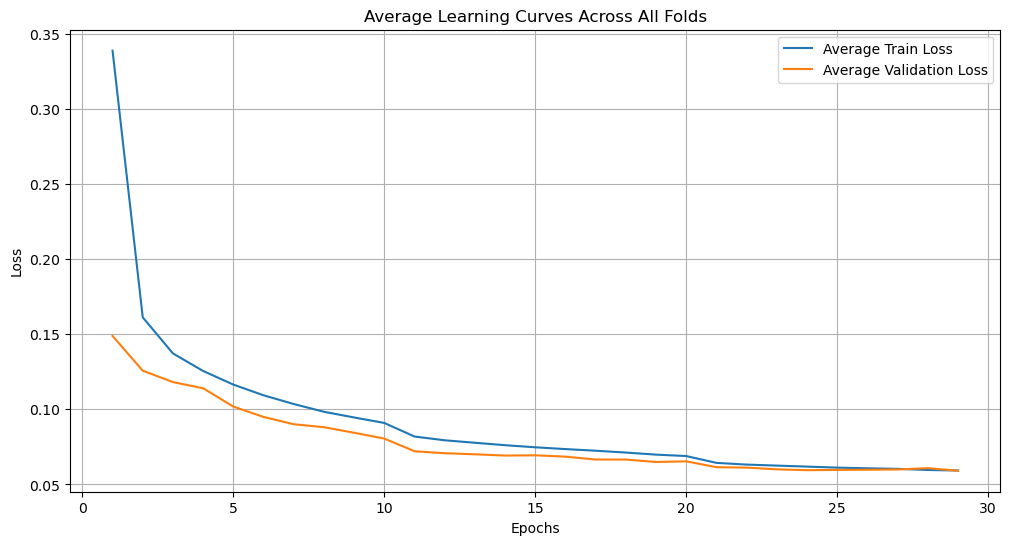

Average Validation Loss across all folds: 0.0614
время на один тип клеток: 211.34706783294678
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Immune_general.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.2071
Validation Loss for Epoch 1: 0.1284
Saved best overall model with Validation Loss: 0.1284
Epoch [2/100], Train Loss: 0.1405
Validation Loss for Epoch 2: 0.1122
Saved best overall model with Validation Loss: 0.1122
Epoch [3/100], Train Loss: 0.1234
Validation Loss for Epoch 3: 0.0984
Saved best overall model with Validation Loss: 0.0984
Epoch [4/100], Train Loss: 0.1124
Validation Loss for Epoch 4: 0.0882
Saved best overall model with Validation Loss: 0.0882
Epoch [5/100], Train Loss: 0.1044
Validation Loss for Epoch 5: 0.0851
Saved best overall model with Validation Loss: 0.0851
Epoch [6/100], Train Loss: 0.0977
Validation Loss for Epoch 6: 0.0796
Saved best overall model with Validation Loss: 0.0796
Epoch [7/100], Train Loss: 0.0925
Validation Loss for Epoch 7: 0.0749
Saved best overall model with Validation Loss: 0.0749
Epoch [8/100], Train Loss: 0.0879
Validation Loss for Epoch 8: 0.0718
Saved best overall model with Validation Loss: 0.0718
Epoch [9

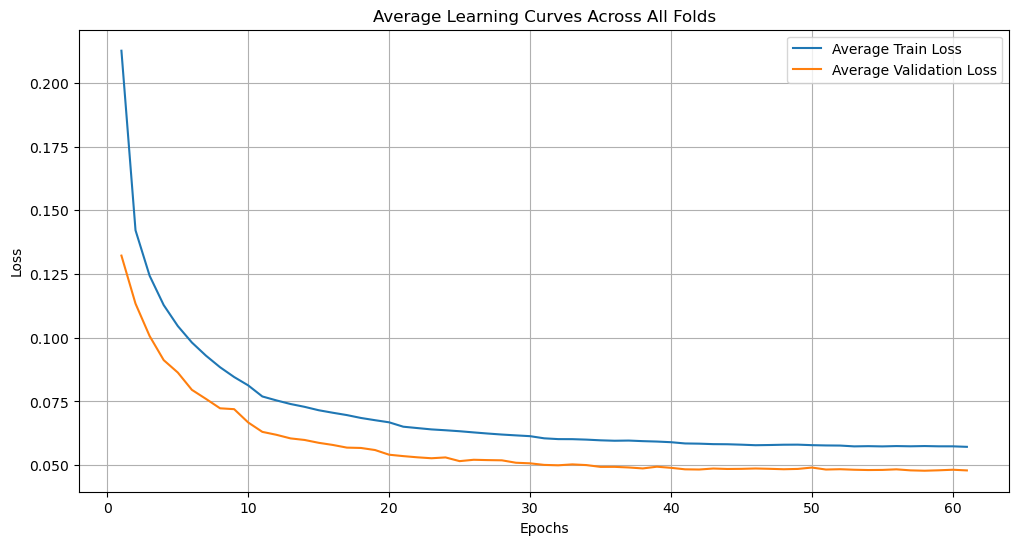

Average Validation Loss across all folds: 0.0496
время на один тип клеток: 217.86013627052307
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Macrophages.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3262
Validation Loss for Epoch 1: 0.1649
Saved best overall model with Validation Loss: 0.1649
Epoch [2/100], Train Loss: 0.2002
Validation Loss for Epoch 2: 0.1314
Saved best overall model with Validation Loss: 0.1314
Epoch [3/100], Train Loss: 0.1673
Validation Loss for Epoch 3: 0.1161
Saved best overall model with Validation Loss: 0.1161
Epoch [4/100], Train Loss: 0.1496
Validation Loss for Epoch 4: 0.1071
Saved best overall model with Validation Loss: 0.1071
Epoch [5/100], Train Loss: 0.1373
Validation Loss for Epoch 5: 0.0975
Saved best overall model with Validation Loss: 0.0975
Epoch [6/100], Train Loss: 0.1286
Validation Loss for Epoch 6: 0.0922
Saved best overall model with Validation Loss: 0.0922
Epoch [7/100], Train Loss: 0.1215
Validation Loss for Epoch 7: 

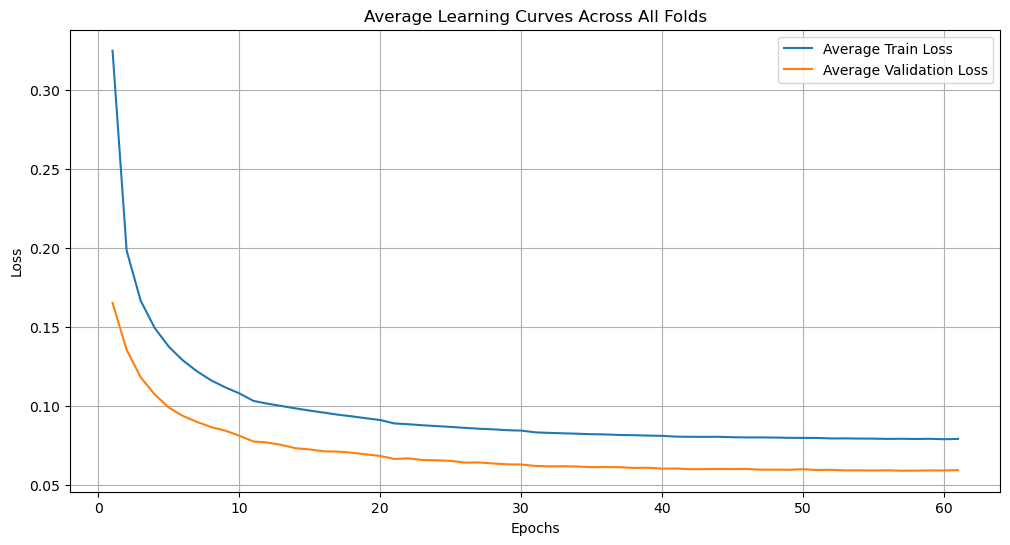

Average Validation Loss across all folds: 0.0592
время на один тип клеток: 285.5841820240021
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Monocytes.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2631
Validation Loss for Epoch 1: 0.1137
Saved best overall model with Validation Loss: 0.1137
Epoch [2/100], Train Loss: 0.1221
Validation Loss for Epoch 2: 0.0820
Saved best overall model with Validation Loss: 0.0820
Epoch [3/100], Train Loss: 0.0984
Validation Loss for Epoch 3: 0.0715
Saved best overall model with Validation Loss: 0.0715
Epoch [4/100], Train Loss: 0.0869
Validation Loss for Epoch 4: 0.0648
Saved best overall model with Validation Loss: 0.0648
Epoch [5/100], Train Loss: 0.0794
Validation Loss for Epoch 5: 0.0625
Saved best overall model with Validation Loss: 0.0625
Epoch [6/100], Train Loss: 0.0746
Validation Loss for Epoch 6: 0.0584
Saved best overall model with Validation Loss: 0.0584
Epoch [7/100], Train Loss: 0.0696
Validation Loss for Epoch 7: 0.0

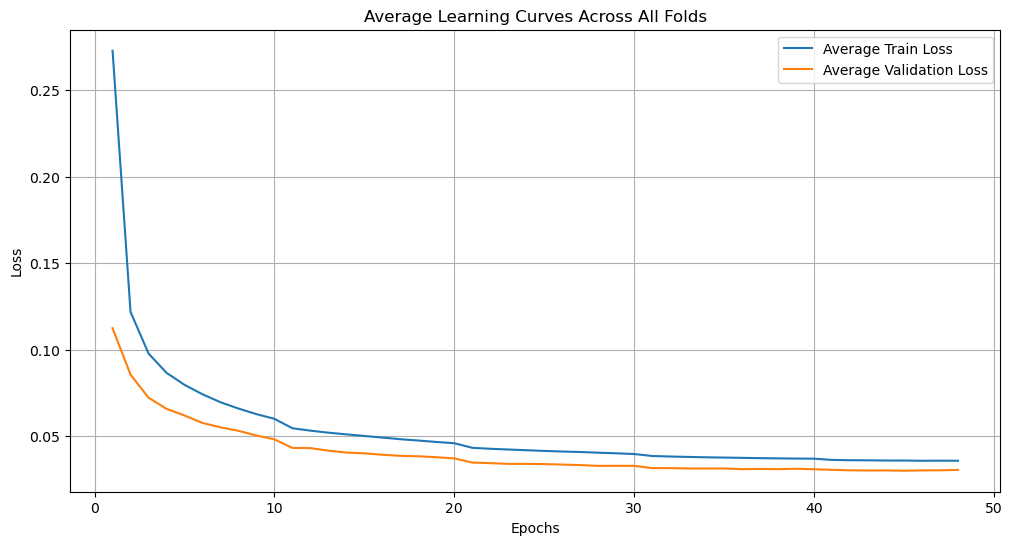

Average Validation Loss across all folds: 0.0305
время на один тип клеток: 253.6792287826538
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Monocytic_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.2643
Validation Loss for Epoch 1: 0.1512
Saved best overall model with Validation Loss: 0.1512
Epoch [2/100], Train Loss: 0.1748
Validation Loss for Epoch 2: 0.1244
Saved best overall model with Validation Loss: 0.1244
Epoch [3/100], Train Loss: 0.1531
Validation Loss for Epoch 3: 0.1114
Saved best overall model with Validation Loss: 0.1114
Epoch [4/100], Train Loss: 0.1417
Validation Loss for Epoch 4: 0.1056
Saved best overall model with Validation Loss: 0.1056
Epoch [5/100], Train Loss: 0.1339
Validation Loss for Epoch 5: 0.0971
Saved best overall model with Validation Loss: 0.0971
Epoch [6/100], Train Loss: 0.1270
Validation Loss for Epoch 6: 0.0937
Saved best overall model with Validation Loss: 0.0937
Epoch [7/100], Train Loss: 0.1218
Validation Loss for Epoch 7: 0.0973
Epoch [8/100], Train Loss: 0.1180
Validation Loss for Epoch 8: 0.0850
Saved best overall model with Validation Loss: 0.0850
Epoch [9/100], Train Loss: 0.1143
Validation Loss for Epoch 9:

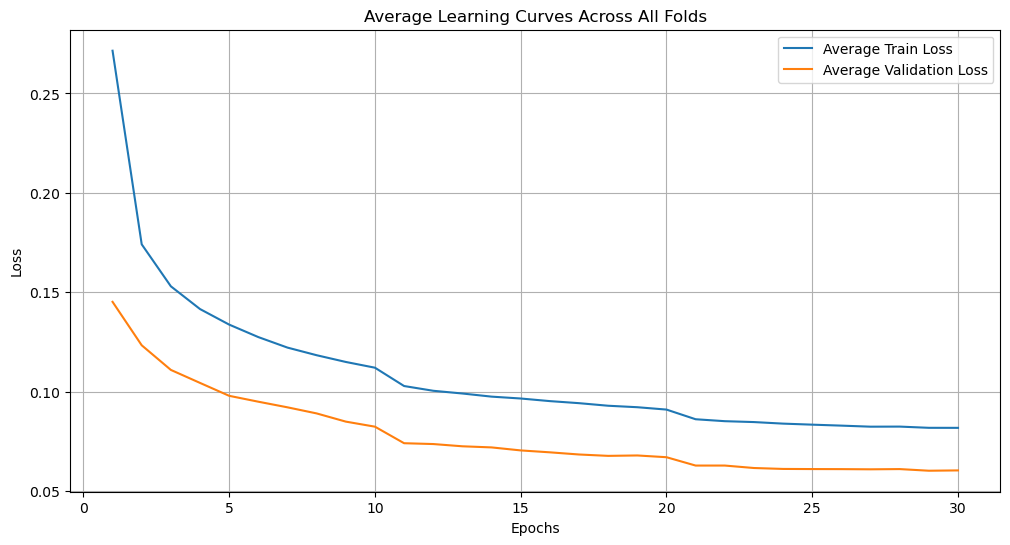

Average Validation Loss across all folds: 0.0642
время на один тип клеток: 186.93230271339417
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_NK_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.3003
Validation Loss for Epoch 1: 0.1509
Saved best overall model with Validation Loss: 0.1509
Epoch [2/100], Train Loss: 0.1576
Validation Loss for Epoch 2: 0.1241
Saved best overall model with Validation Loss: 0.1241
Epoch [3/100], Train Loss: 0.1353
Validation Loss for Epoch 3: 0.1135
Saved best overall model with Validation Loss: 0.1135
Epoch [4/100], Train Loss: 0.1228
Validation Loss for Epoch 4: 0.1025
Saved best overall model with Validation Loss: 0.1025
Epoch [5/100], Train Loss: 0.1148
Validation Loss for Epoch 5: 0.1029
Epoch [6/100], Train Loss: 0.1075
Validation Loss for Epoch 6: 0.0955
Saved best overall model with Validation Loss: 0.0955
Epoch [7/100], Train Loss: 0.1023
Validation Loss for Epoch 7: 0.0910
Saved best overall model with Validation Loss: 0.0910
Epoch [8/100], Train Loss: 0.0973
Validation Loss for Epoch 8: 0.0818
Saved best overall model with Validation Loss: 0.0818
Epoch [9/100], Train Loss: 0.0925
Validation Loss for Epoch 9:

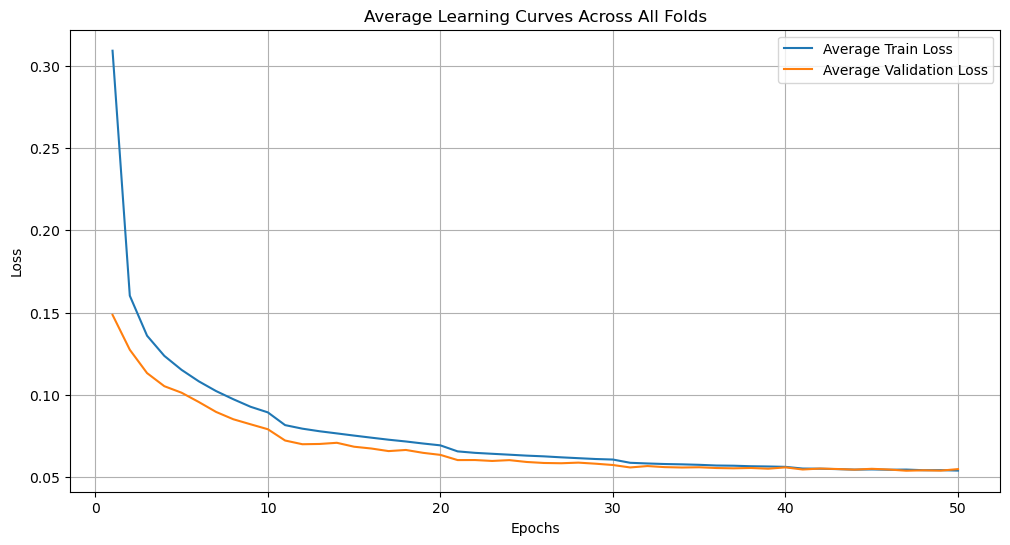

Average Validation Loss across all folds: 0.0559
время на один тип клеток: 223.85557293891907
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Non_plasma_B_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.3434
Validation Loss for Epoch 1: 0.1821
Saved best overall model with Validation Loss: 0.1821
Epoch [2/100], Train Loss: 0.2049
Validation Loss for Epoch 2: 0.1494
Saved best overall model with Validation Loss: 0.1494
Epoch [3/100], Train Loss: 0.1736
Validation Loss for Epoch 3: 0.1340
Saved best overall model with Validation Loss: 0.1340
Epoch [4/100], Train Loss: 0.1553
Validation Loss for Epoch 4: 0.1347
Epoch [5/100], Train Loss: 0.1419
Validation Loss for Epoch 5: 0.1162
Saved best overall model with Validation Loss: 0.1162
Epoch [6/100], Train Loss: 0.1326
Validation Loss for Epoch 6: 0.1063
Saved best overall model with Validation Loss: 0.1063
Epoch [7/100], Train Loss: 0.1256
Validation Loss for Epoch 7: 0.1029
Saved best overall model with Validation Loss: 0.1029
Epoch [8/100], Train Loss: 0.1204
Validation Loss for Epoch 8: 0.0985
Saved best overall model with Validation Loss: 0.0985
Epoch [9/100], Train Loss: 0.1169
Validation Loss for Epoch 9:

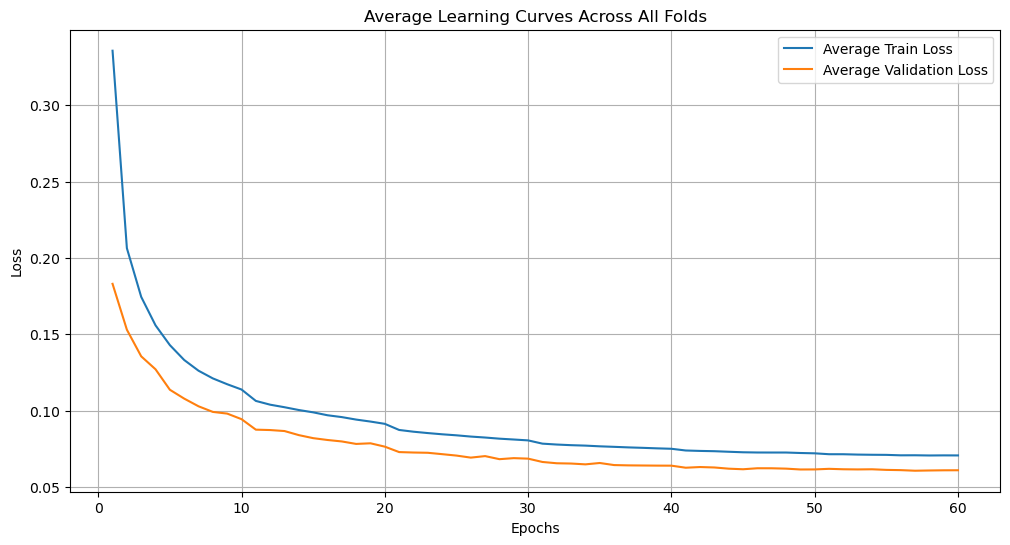

Average Validation Loss across all folds: 0.0618
время на один тип клеток: 297.8124089241028
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Plasma_B_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.4274
Validation Loss for Epoch 1: 0.2177
Saved best overall model with Validation Loss: 0.2177
Epoch [2/100], Train Loss: 0.2307
Validation Loss for Epoch 2: 0.1748
Saved best overall model with Validation Loss: 0.1748
Epoch [3/100], Train Loss: 0.1959
Validation Loss for Epoch 3: 0.1519
Saved best overall model with Validation Loss: 0.1519
Epoch [4/100], Train Loss: 0.1795
Validation Loss for Epoch 4: 0.1404
Saved best overall model with Validation Loss: 0.1404
Epoch [5/100], Train Loss: 0.1695
Validation Loss for Epoch 5: 0.1401
Saved best overall model with Validation Loss: 0.1401
Epoch [6/100], Train Loss: 0.1633
Validation Loss for Epoch 6: 0.1388
Saved best overall model with Validation Loss: 0.1388
Epoch [7/100], Train Loss: 0.1567
Validation Loss for Epoch 7

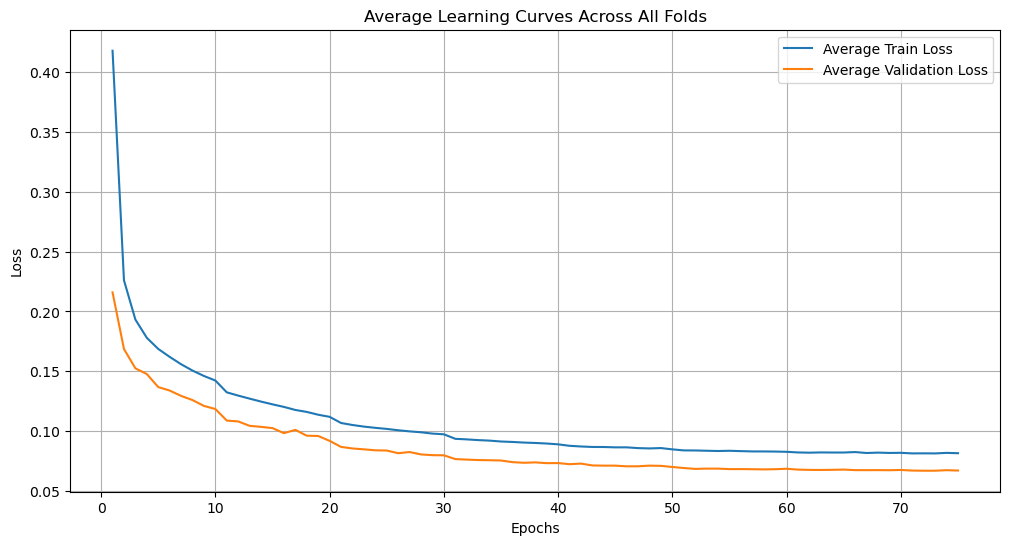

Average Validation Loss across all folds: 0.0742
время на один тип клеток: 253.2130343914032
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2914
Validation Loss for Epoch 1: 0.1372
Saved best overall model with Validation Loss: 0.1372
Epoch [2/100], Train Loss: 0.1499
Validation Loss for Epoch 2: 0.1171
Saved best overall model with Validation Loss: 0.1171
Epoch [3/100], Train Loss: 0.1286
Validation Loss for Epoch 3: 0.1124
Saved best overall model with Validation Loss: 0.1124
Epoch [4/100], Train Loss: 0.1181
Validation Loss for Epoch 4: 0.1019
Saved best overall model with Validation Loss: 0.1019
Epoch [5/100], Train Loss: 0.1111
Validation Loss for Epoch 5: 0.0939
Saved best overall model with Validation Loss: 0.0939
Epoch [6/100], Train Loss: 0.1046
Validation Loss for Epoch 6: 0.0891
Saved best overall model with Validation Loss: 0.0891
Epoch [7/100], Train Loss: 0.0992
Validation Loss for Epoch 7: 0.084

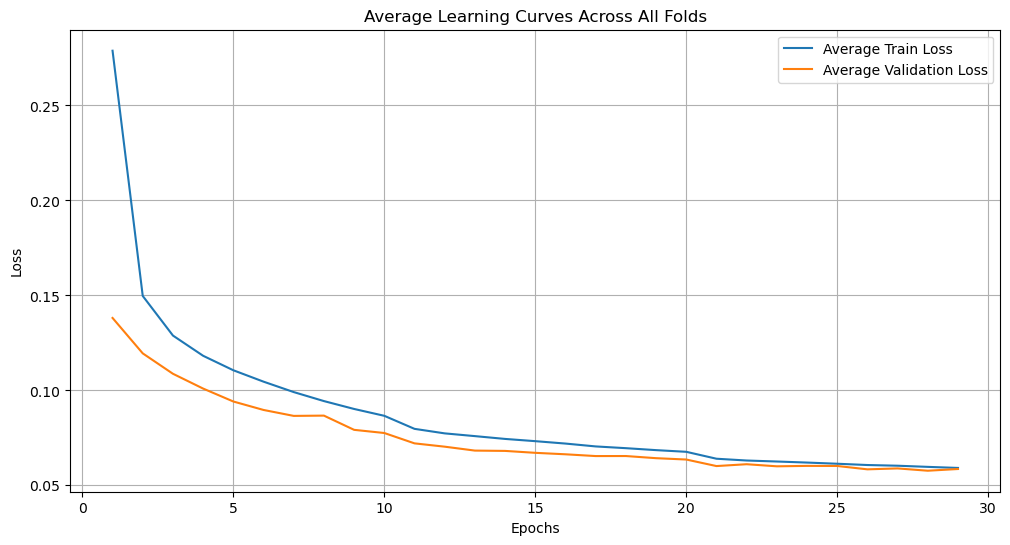

Average Validation Loss across all folds: 0.0603
время на один тип клеток: 152.68721508979797


In [87]:
for selected_cell in cells:
    start = time.time()

    selected_genes = cell_types[selected_cell].genes.copy()
    if selected_cell != 'Immune_general':
        selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
    
    
    expr_train, values_train = mixer_train.generate(selected_cell, 
                                                genes = selected_genes,
                                                random_seed=17)
    expr_train = renorm_expressions(expr_train, genes_in_expression_file)
    params = load_model_params(selected_cell)
    hidden_dim = params["hidden_dim"]
    nhead = params["nhead"]
    num_layers = params["num_layers"]
    latent_dim = params["latent_dim"]
    lr = params["lr"]
    weight_decay = params["weight_decay"]

    data = expr_train
    targets = values_train
    input_dim = data.shape[0] 
    output_dim = targets.shape[0]  
    
    criterion = nn.KLDivLoss(reduction='batchmean')
    
    batch_size = 256
    num_epochs = 100
    patience = 3
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X_train_tensor = torch.tensor(data.T.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(targets.T.values, dtype=torch.float32)

    fold_metrics = []

    all_train_losses = []
    all_val_losses = []
    
    best_overall_val_loss = float('inf')
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        X_train_fold = X_train_tensor[train_idx]
        y_train_fold = y_train_tensor[train_idx]
        X_val_fold = X_train_tensor[val_idx]
        y_val_fold = y_train_tensor[val_idx]
    
        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)
        
        model = TransDeconv(input_dim, hidden_dim, nhead, num_layers, latent_dim, output_dim).to(device) 
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        
        train_losses = []
        val_losses = []
        
        best_val_loss = float('inf')
        patience_counter = 0
        
    
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
    
                outputs = model(batch_X)
                
                loss = criterion(outputs, batch_y)
                
    
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_train_loss += loss.item()
            
            scheduler.step() 
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
            
    
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    
                    # Loss
                    loss = criterion(outputs, batch_y)
                    total_val_loss += loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")
            
    
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                
    
                if best_val_loss < best_overall_val_loss:
                    best_overall_val_loss = best_val_loss
                    best_model_path = f"./best_{selected_cell}_trans.pth"
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Saved best overall model with Validation Loss: {best_overall_val_loss:.4f}")
            
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break
        
        fold_metrics.append(best_val_loss)
        print(f"Best Validation Loss for Fold {fold + 1}: {best_val_loss:.4f}\n")
    
        
    
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
    
    
    max_len = max(len(lst) for lst in all_train_losses)
    all_train_losses_padded = [lst + [float('nan')] * (max_len - len(lst)) for lst in all_train_losses]
    all_val_losses_padded = [lst + [float('nan')] * (max_len - len(lst)) for lst in all_val_losses]
    
    avg_train_losses = np.nanmean(all_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(all_val_losses_padded, axis=0)
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Average Train Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Average Validation Loss')
    plt.title('Average Learning Curves Across All Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    print(f"Average Validation Loss across all folds: {np.mean(fold_metrics):.4f}")
    model.load_state_dict(torch.load(f"best_{selected_cell}_trans.pth"))   
    model.to("cpu")
    model.eval()

    dummy_expr, dummy_targets = mixer_test.generate(selected_cell,
                                                    selected_genes,
                                                    random_seed=17)
    dummy_input = renorm_expressions(dummy_expr, genes_in_expression_file)
    test_input = torch.tensor(dummy_input.T.values,
                           dtype=torch.float32)
    onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'
    torch.onnx.export(
        model,
        test_input,
        onnx_model_path,
    
        export_params=True,
    
        opset_version=14,
    
        do_constant_folding=False,
        input_names=['bulk_normalized_vector'],
        output_names=['cell_proportions'],
        dynamic_axes={
            'bulk_normalized_vector': {0: 'batch_size'},  
            'cell_proportions': {0: 'batch_size'}
        }
    )
    end = time.time()
    print(f"время на один тип клеток: {end - start}")

# Uploading

## ConvNeXt

In [11]:
model_Immune_general = ConvNeXt1DForProportions(depths=[3,3,6])
model_Immune_general.load_state_dict(torch.load(f'Immune_general_best_model_336_power789.pth', weights_only=True))

<All keys matched successfully>

In [26]:
model_Non_Plasma_B_cells = ConvNeXt1DForProportions(num_cells=10)
model_Non_Plasma_B_cells.load_state_dict(torch.load(f'best_Non_plasma_B_cells_ConvNeXt.pth', weights_only=True))

<All keys matched successfully>

In [42]:
model_B_cells = ConvNeXt1DForProportions(num_cells=9)
model_B_cells.load_state_dict(torch.load(f'best_ConvNeXt.pth'))

<All keys matched successfully>

## Transformers

In [115]:
dataset = 'Publication validation set'
cytof = pd.read_csv('data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)
expr = pd.read_csv('data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)
final_predictions = pd.DataFrame()


for selected_cell in cells:
    print(f"Predicting for {selected_cell}...")


    onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'

    selected_genes = cell_types[selected_cell].genes.copy()
    if selected_cell != 'Immune_general':
        selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])    


    val_genes = selected_genes
    val_expr = expr.loc[selected_genes]
    val_expr = renorm_expressions(val_expr, genes_in_expression_file)
    X_test = torch.tensor(val_expr.T.values, dtype=torch.float32)
    dummy_data, dummy_target = mixer_test.generate(selected_cell,
                                       selected_genes,
                                       random_seed=17)
    indeces = dummy_target.index.copy()
    dummy_input = X_test 


    try:
        onnx_model = onnx.load(onnx_model_path)
        onnx.checker.check_model(onnx_model)
        
        ort_session = ort.InferenceSession(onnx_model_path)
    except Exception as e:
        print(f"Ошибка при загрузке модели для {selected_cell}: {e}")
        continue

    all_outputs = []

    for i in range(dummy_input.shape[0]):
        single_sample = dummy_input[i:i+1]  

        outputs = ort_session.run(
            None,
            {'bulk_normalized_vector': single_sample.numpy()}
        )[0]

        all_outputs.append(outputs)

    outputs = np.vstack(all_outputs) 
    predictions = np.exp(outputs.T)*100

    df_pred = pd.DataFrame(predictions, index=indeces, columns=expr.columns)


    df_pred_filtered = df_pred.drop(index=selected_cell, errors='ignore')
    final_predictions = pd.concat([final_predictions, df_pred_filtered], axis=0)
    

predictions = final_predictions.groupby(final_predictions.index, sort=False).mean()

Predicting for B_cells...
Predicting for CD4_T_cells...
Predicting for CD8_T_cells...
Predicting for Dendritic_cells...
Predicting for Endothelium...
Predicting for Fibroblasts...
Predicting for Granulocytes...
Predicting for Immune_general...
Predicting for Macrophages...
Predicting for Monocytes...
Predicting for Monocytic_cells...
Predicting for NK_cells...
Predicting for Non_plasma_B_cells...
Predicting for Plasma_B_cells...
Predicting for T_cells...


# Benchmarking

## Functions to process predictions

In [78]:
def adjust_rna_fractions(preds: pd.DataFrame,
                         cell_config_path: str, add_other: bool = False) -> pd.DataFrame:
    """
    Adjust predictions to respect hierarchy of cell types.
    Each subtype is scaled to sum up to its parent's value.

    :param preds: DataFrame with predictions (samples x cell types)
    :param cell_config_path: Path to cell config YAML
    :param add_other: Whether to add 'Other' class if sum < 1
    :return: Adjusted predictions
    """
    with open(cell_config_path, "r") as f:
        config = yaml.safe_load(f)

    
    root = next(ct for ct in config if config[ct].get("parent_type") is None)

    
    available_types = preds.index.tolist()

    
    general_types = [ct for ct in config[root].get("subtypes", []) if ct in available_types]

    preds = preds.copy()
    preds[preds < 0] = 0

    
    for sample in preds.index:
        total = preds.loc[sample, general_types].sum()
        if total < 1 and add_other:
            preds.loc[sample, "Other"] = 1 - total
        else:
            preds.loc[sample, general_types] /= total
            preds.loc[sample, "Other"] = 0

    
    queue = general_types[:]
    while queue:
        cell = queue.pop()
        subtypes = config[cell].get("subtypes", [])
        subtypes = [ct for ct in subtypes if ct in preds.columns]

        if not subtypes:
            continue

        total = preds[subtypes].sum(axis=1)
        preds[subtypes] = preds[subtypes].divide(total, axis=0).multiply(preds[cell], axis=0)
        queue = subtypes + queue

    return preds


def convert_rna_to_cells_fractions(
    rna_fractions: pd.DataFrame, cell_config_path: str, other_coeff: float = 1.0
) -> pd.DataFrame:
    """
    Converts RNA fractions into real cell fractions using rna_per_cell coefficients.

    :param rna_fractions: RNA-based predicted fractions (cell types x samples)
    :param cell_config_path: Path to cell config YAML
    :param other_coeff: Coefficient for 'Other' class
    :return: Final adjusted cell fractions (cell types x samples)
    """
    with open(cell_config_path, "r") as f:
        config = yaml.safe_load(f)

    # Все типы из preds (в индексе)
    available_types = rna_fractions.index.tolist()

    # Определяем терминальные типы (без подтипов)
    def is_terminal(cell):
        subtypes = config[cell].get("subtypes", [])
        return not any(st in available_types for st in subtypes)

    terminal_models = [ct for ct in available_types if is_terminal(ct)]

    # Коэффициенты
    coefs = {"Other": other_coeff}
    for cell in terminal_models:
        coefs[cell] = config[cell].get("rna_per_cell", 1.0)  # Если NULL → 1.0

    coefs = pd.Series(coefs)

    # Применяем коэффициенты
    cells_fractions = rna_fractions.loc[terminal_models].copy()

    # Добавляем 'Other'
    cells_fractions.loc["Other"] = 1 - cells_fractions.sum(axis=0).clip(upper=1.0)
    cells_fractions = cells_fractions.mul(coefs, axis=0)

    # Нормализуем
    total = cells_fractions.sum(axis=0).replace(0, 1e-8)
    cells_fractions = cells_fractions.div(total, axis=1)

    # Суммируем вверх по иерархии
    non_terminal_models = [ct for ct in available_types if not is_terminal(ct)]

    while non_terminal_models:
        m = non_terminal_models.pop()
        subtypes = config[m].get("subtypes", [])
        subtypes_in_model = [ct for ct in subtypes if ct in cells_fractions.index]

        skip = [ct for ct in subtypes_in_model if ct in non_terminal_models]
        if skip:
            non_terminal_models = [m] + non_terminal_models
        else:
            # Если нет подтипов — ставим 0
            if not subtypes_in_model:
                cells_fractions.loc[m] = 0.0
            else:
                cells_fractions.loc[m] = cells_fractions.loc[subtypes_in_model].sum(axis=0)

    # Заполняем NaN нулями (если тип не был найден)
    cells_fractions = cells_fractions.fillna(0)

    return cells_fractions

## ConvNeXt

In [95]:
dataset = 'Publication validation set'
cytof = pd.read_csv('data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)
expr = pd.read_csv('data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)
selected_cell = 'B_cells'

In [96]:
selected_genes = cell_types[selected_cell].genes
if selected_genes != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
val_expr = expr.loc[selected_genes]
val_expr = renorm_expressions(val_expr, genes_in_expression_file)

val_expr

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0627,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462
Gene,,,,,,,,,,,,,,,,,,,,,
DENND1C,1051.641645,1315.387245,992.205544,1585.520270,1019.441101,1720.116989,855.484658,1572.180807,1508.935839,1485.084983,...,1227.854573,1141.736320,767.456189,799.857450,991.666247,1132.292096,1026.350759,1232.943625,1373.672100,1258.845417
GPR174,228.767173,378.793113,198.709605,301.864828,171.408050,475.932512,109.589756,537.303424,410.430879,578.176190,...,290.435800,192.328492,71.500496,92.657771,202.035361,188.775576,250.464716,515.304825,631.397871,209.377766
IL2RB,717.609658,2923.132256,830.703026,2991.698035,954.028382,3962.058145,614.570177,1935.401262,1519.373666,1991.730578,...,1335.399890,1050.305219,636.244884,493.691609,954.424533,611.861664,1240.717658,1323.821491,1462.456718,1126.126563
PADI2,3189.052505,1839.030050,3028.019122,1701.969796,3006.424020,1350.920145,1480.147931,841.817282,498.249332,783.024996,...,831.915045,899.032324,2440.619494,3395.902938,1760.001569,838.574864,1879.126969,1068.239319,957.591068,1799.249045
ARHGAP30,3919.927836,4466.351451,3720.586187,4725.550325,3997.294073,4758.115771,4777.023957,5182.285638,5504.151924,5256.675191,...,3960.159755,4302.798383,4090.885601,4085.548526,3707.247314,4265.675221,4035.111167,4587.973355,3798.266775,4507.214766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STK4,1892.871133,2052.884390,1607.035264,1897.043743,1590.204555,1874.515278,1582.630287,2131.700035,2039.379677,2270.062908,...,1944.319260,1973.476398,1663.085207,1400.939815,1488.249234,1651.191736,1684.135874,1924.812677,2535.039851,1907.213551
VSIG4,40.369028,58.676055,34.319326,58.147523,34.492476,82.589036,93.629451,191.328085,108.464452,31.634582,...,97.226453,45.175547,52.058963,17.316235,80.330291,75.401493,53.270633,99.417317,46.945899,33.373658
ELF1,1767.310141,2109.773249,1512.247368,1773.063257,1345.068978,2303.416182,1921.164382,2308.967771,2545.921945,2276.771927,...,2124.254193,1984.874556,1581.362964,1723.001321,1905.066459,1920.496553,1948.551224,2015.205376,2767.718270,2007.734661


In [97]:
expr_test, values_test = mixer_test.generate(selected_cell, selected_genes)
values_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NK_cells,1.287249e-04,0.198225,2.531772e-11,3.139981e-02,5.184046e-06,9.967958e-07,4.278683e-13,5.842998e-08,1.354242e-01,0.033203,...,5.209311e-06,0.002386,0.240569,1.387207e-07,8.324625e-06,1.525394e-02,2.001434e-10,1.043044e-07,1.522162e-02,5.451839e-16
Monocytic_cells,4.741077e-04,0.000352,3.348933e-10,5.231535e-07,2.971332e-07,1.303626e-07,5.037916e-05,2.389752e-09,4.194142e-02,0.000007,...,3.257433e-02,0.047881,0.113567,4.751114e-15,9.528372e-05,9.544870e-06,2.183455e-04,3.472231e-02,2.836028e-02,2.295531e-06
T_cells,3.421682e-04,0.005742,1.242724e-01,3.061327e-03,1.376728e-05,1.695553e-01,5.707354e-04,2.660039e-04,1.144653e-04,0.000464,...,3.407903e-07,0.007537,0.000592,1.448975e-05,2.769566e-03,1.246610e-02,4.562612e-04,1.328428e-01,1.722547e-03,5.861650e-03
Granulocytes,5.066686e-10,0.000002,4.632075e-03,8.026862e-03,1.315940e-10,3.634766e-02,3.159627e-07,2.819394e-02,2.957305e-01,0.000067,...,2.079628e-05,0.000267,0.051545,2.250778e-01,3.884548e-06,1.894007e-03,1.900675e-05,1.503769e-01,1.010616e-08,4.403131e-02
Dendritic_cells,1.270152e-02,0.000021,5.275855e-07,1.817723e-01,1.375714e-02,7.309185e-09,2.432952e-04,1.742248e-05,1.201468e-08,0.082518,...,9.565499e-02,0.001943,0.002429,2.323635e-02,1.586052e-04,6.403892e-02,3.589368e-02,1.311467e-04,1.576734e-07,1.631571e-07
Endothelium,5.177267e-08,0.000011,4.165783e-02,1.552124e-08,1.538939e-03,1.185129e-01,1.371924e-02,9.636044e-03,2.918793e-03,0.001129,...,2.992071e-02,0.000145,0.000012,1.354810e-04,2.302855e-01,5.269997e-11,6.024585e-06,2.929593e-01,8.221053e-02,8.299118e-05
Fibroblasts,9.429689e-04,0.148612,2.495465e-05,1.890191e-01,3.088788e-07,5.476591e-11,2.206317e-02,1.029454e-02,1.713722e-03,0.264855,...,5.165068e-05,0.010011,0.000068,9.703201e-03,6.213005e-15,1.962098e-01,2.045284e-03,1.673941e-02,5.128015e-05,5.259295e-12
B_cells,1.455043e-04,0.545717,1.843658e-01,4.052107e-02,2.362987e-01,6.452262e-01,2.154753e-01,9.166741e-02,5.189555e-01,0.261283,...,1.931635e-01,0.539011,0.473211,2.349938e-01,6.262470e-02,2.399189e-01,5.185589e-01,1.935862e-02,9.919255e-02,1.949289e-02
Tumor,9.852650e-01,0.101318,6.450464e-01,5.461990e-01,7.483856e-01,3.035682e-02,7.478776e-01,8.599246e-01,3.201399e-03,0.356474,...,6.486084e-01,0.390819,0.118007,5.068387e-01,7.040542e-01,4.702087e-01,4.428025e-01,3.528694e-01,7.732410e-01,9.305287e-01


In [98]:
X_test = torch.tensor(val_expr.T.values, dtype = torch.float32)
model_B_cells.to(device)
model_B_cells.eval()
with torch.no_grad():
    inputs = X_test.unsqueeze(1).to(device)
    outputs = model_B_cells(inputs)
outputs
validation = pd.DataFrame(outputs.to("cpu").T*100, index=values_test.index,
                          columns=val_expr.columns)
validation

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0627,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462
NK_cells,3.172485,6.231004,3.510581,6.740983,3.920808,9.702235,1.916153,3.493798,4.073274,4.609581,...,2.677246,2.322397,1.491394,1.689291,2.829988,1.132529,2.713155,4.829835,3.106924,2.111230
Monocytic_cells,15.322579,7.982385,14.610558,9.937421,15.149893,11.687068,22.176781,30.671402,32.704998,40.929947,...,6.246478,15.142380,7.961513,3.375425,7.461988,7.480251,14.471607,6.949030,10.449099,7.578153
T_cells,4.713770,12.799846,3.158726,10.209527,3.383611,16.143414,2.707680,20.867704,9.081603,12.134354,...,12.797841,4.591000,1.992319,2.127178,4.000781,4.310714,7.870728,19.625397,14.444611,6.106256
Granulocytes,36.622822,32.243603,38.117580,23.111374,31.170502,11.716902,25.421473,0.883748,0.987589,0.849851,...,32.068680,22.908722,42.880939,52.921558,44.008167,31.421152,32.389828,13.472183,14.622911,43.643658
Dendritic_cells,13.742137,14.892263,14.227305,23.213396,16.174299,23.286535,9.169866,4.810927,9.808414,4.204347,...,18.427670,17.053499,6.552515,4.977987,12.612221,11.095673,10.099796,17.495203,24.587099,6.924784
Endothelium,1.680359,1.518016,1.524050,1.372828,1.857070,1.249146,1.648843,1.982908,2.744589,1.848821,...,1.496814,1.001574,1.257239,1.574254,1.314902,1.236093,1.476008,0.859762,1.116784,1.191158
Fibroblasts,1.433569,1.464727,1.502923,1.385554,1.680227,1.360481,1.438014,1.553899,1.810739,1.552855,...,1.342906,1.195141,2.005091,1.905872,1.381779,2.156784,1.510683,1.602374,1.219098,2.007010
B_cells,7.197441,7.032456,6.386529,7.179187,6.091423,8.065600,7.423650,13.020450,14.855902,12.437334,...,8.697695,10.396349,4.407676,5.482917,6.198814,7.702165,8.204295,11.178931,9.363268,6.467244
Tumor,16.114830,15.835693,16.961746,16.849720,20.572159,16.788622,28.097534,22.715166,23.932896,21.432913,...,16.244669,25.388935,31.451309,25.945524,20.191362,33.464645,21.263901,23.987289,21.090204,23.970514


In [99]:
adjusted_preds = adjust_rna_fractions(validation.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)

final_predictions = convert_rna_to_cells_fractions(adjusted_preds, "./configs/cell_types.yaml", other_coeff=1.0)

# final_predictions.to_csv("final_cell_proportions.csv")

In [100]:
final_predictions

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462,Other
B_cells,0.061064,0.059949,0.053225,0.077314,0.059641,0.112214,0.089017,0.314564,0.440728,0.377713,...,0.124018,0.035060,0.035638,0.045776,0.076088,0.075143,0.145524,0.128200,0.048026,0.162041
Dendritic_cells,0.030313,0.033007,0.030828,0.064997,0.041174,0.084234,0.028589,0.030219,0.075656,0.033198,...,0.052892,0.013551,0.008413,0.024216,0.028499,0.024051,0.059214,0.087527,0.013370,0.042131
Endothelium,0.001490,0.001353,0.001328,0.001546,0.001901,0.001817,0.002067,0.005008,0.008512,0.005870,...,0.001249,0.001045,0.001070,0.001015,0.001277,0.001413,0.001170,0.001598,0.000925,0.016940
Fibroblasts,0.001298,0.001333,0.001337,0.001593,0.001756,0.002020,0.001840,0.004007,0.005734,0.005033,...,0.001522,0.001702,0.001322,0.001089,0.002274,0.001477,0.002226,0.001782,0.001591,0.017295
Granulocytes,0.838926,0.742129,0.857702,0.672007,0.824011,0.440135,0.823042,0.057647,0.079106,0.069685,...,0.737850,0.920931,0.928751,0.877461,0.838089,0.800978,0.473516,0.540580,0.875065,0.437511
Monocytic_cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK_cells,0.026916,0.053117,0.029257,0.072595,0.038388,0.134984,0.022977,0.084407,0.120841,0.139990,...,0.027704,0.011863,0.010980,0.020899,0.011188,0.024850,0.062873,0.042540,0.015678,0.162041
Other,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T_cells,0.039992,0.109113,0.026324,0.109949,0.033129,0.224597,0.032468,0.504148,0.269423,0.368512,...,0.054766,0.015847,0.013826,0.029544,0.042585,0.072088,0.255477,0.197773,0.045345,0.162041


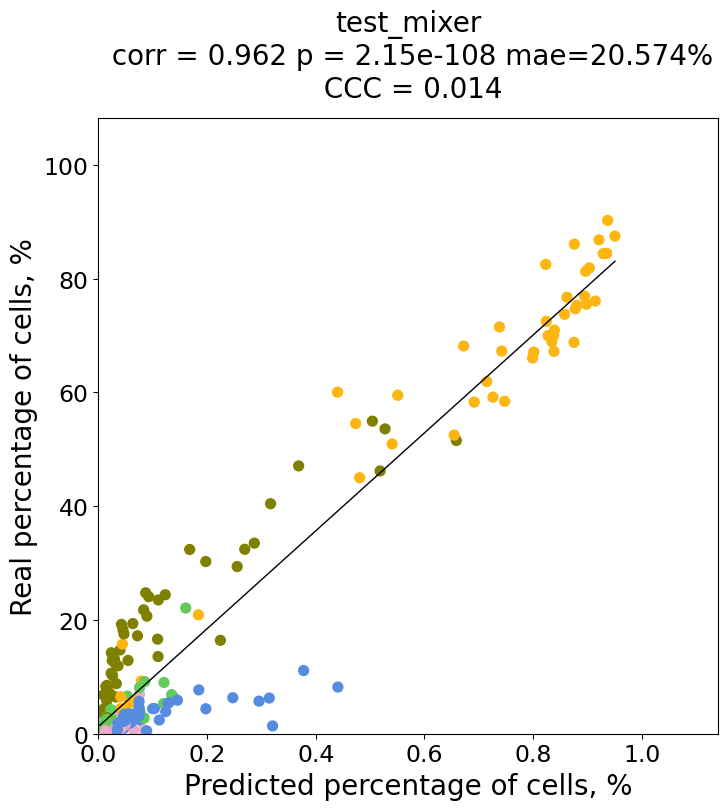

In [101]:
x = print_all_cells_in_one(final_predictions, 
                           cytof,
                           pallete=cells_p,
                           title='test_mixer', min_xlim=0, min_ylim=0)
# plt.savefig('convnext_all_in_one.jpg', dpi=600, bbox_inches='tight', transparent=False)

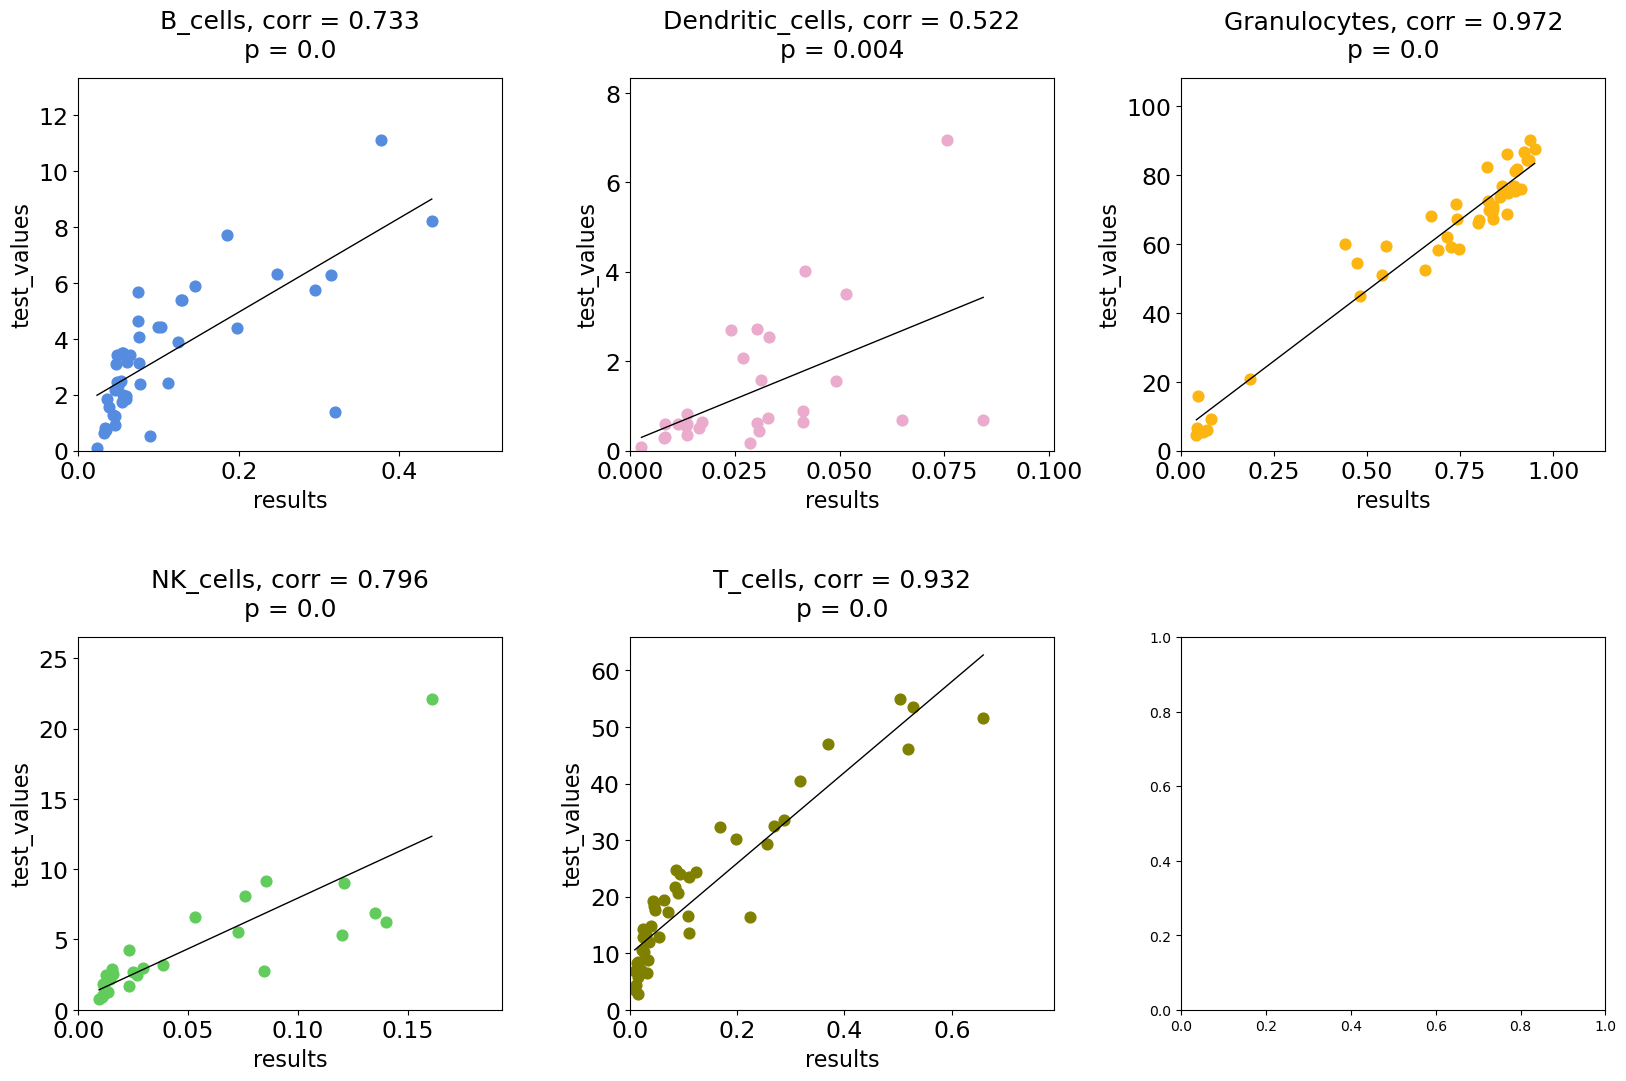

In [102]:
x = print_cell_matras(final_predictions, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

# plt.savefig('convnext_cells.jpg', dpi=600,  bbox_inches='tight', transparent=False)

## Transformers

In [89]:
adjusted_preds_trans = adjust_rna_fractions(predictions.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)

final_predictions_trans = convert_rna_to_cells_fractions(adjusted_preds_trans, "./configs/cell_types.yaml", other_coeff=1.0)

In [90]:
final_predictions_trans.loc['Lymphocytes'] = final_predictions_trans.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [109]:
final_predictions

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462,Other
B_cells,0.061064,0.059949,0.053225,0.077314,0.059641,0.112214,0.089017,0.314564,0.440728,0.377713,...,0.124018,0.035060,0.035638,0.045776,0.076088,0.075143,0.145524,0.128200,0.048026,0.162041
Dendritic_cells,0.030313,0.033007,0.030828,0.064997,0.041174,0.084234,0.028589,0.030219,0.075656,0.033198,...,0.052892,0.013551,0.008413,0.024216,0.028499,0.024051,0.059214,0.087527,0.013370,0.042131
Endothelium,0.001490,0.001353,0.001328,0.001546,0.001901,0.001817,0.002067,0.005008,0.008512,0.005870,...,0.001249,0.001045,0.001070,0.001015,0.001277,0.001413,0.001170,0.001598,0.000925,0.016940
Fibroblasts,0.001298,0.001333,0.001337,0.001593,0.001756,0.002020,0.001840,0.004007,0.005734,0.005033,...,0.001522,0.001702,0.001322,0.001089,0.002274,0.001477,0.002226,0.001782,0.001591,0.017295
Granulocytes,0.838926,0.742129,0.857702,0.672007,0.824011,0.440135,0.823042,0.057647,0.079106,0.069685,...,0.737850,0.920931,0.928751,0.877461,0.838089,0.800978,0.473516,0.540580,0.875065,0.437511
Monocytic_cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK_cells,0.026916,0.053117,0.029257,0.072595,0.038388,0.134984,0.022977,0.084407,0.120841,0.139990,...,0.027704,0.011863,0.010980,0.020899,0.011188,0.024850,0.062873,0.042540,0.015678,0.162041
Other,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T_cells,0.039992,0.109113,0.026324,0.109949,0.033129,0.224597,0.032468,0.504148,0.269423,0.368512,...,0.054766,0.015847,0.013826,0.029544,0.042585,0.072088,0.255477,0.197773,0.045345,0.162041


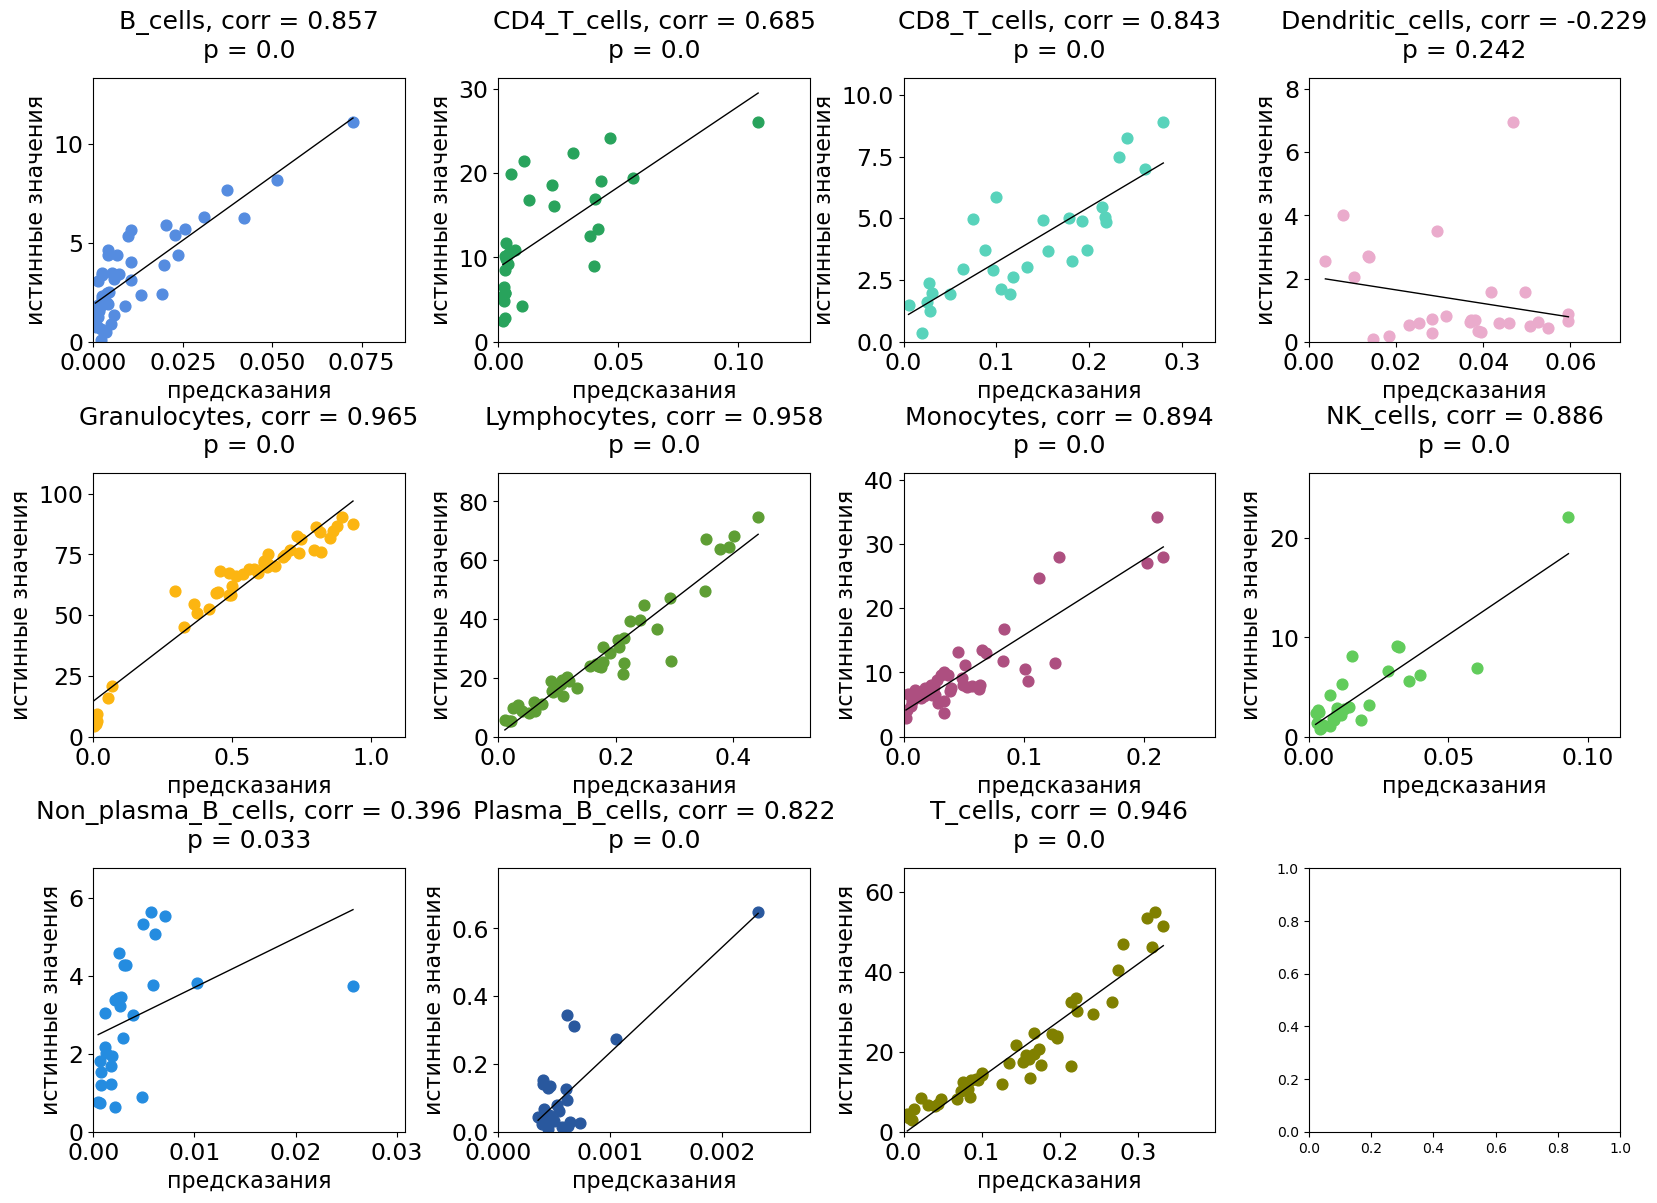

In [91]:
x = print_cell_matras(final_predictions_trans, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='истинные значения', predicted_name='предсказания',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

# plt.savefig("all_transformers.png", dpi=1200, bbox_inches='tight', transparent=False)

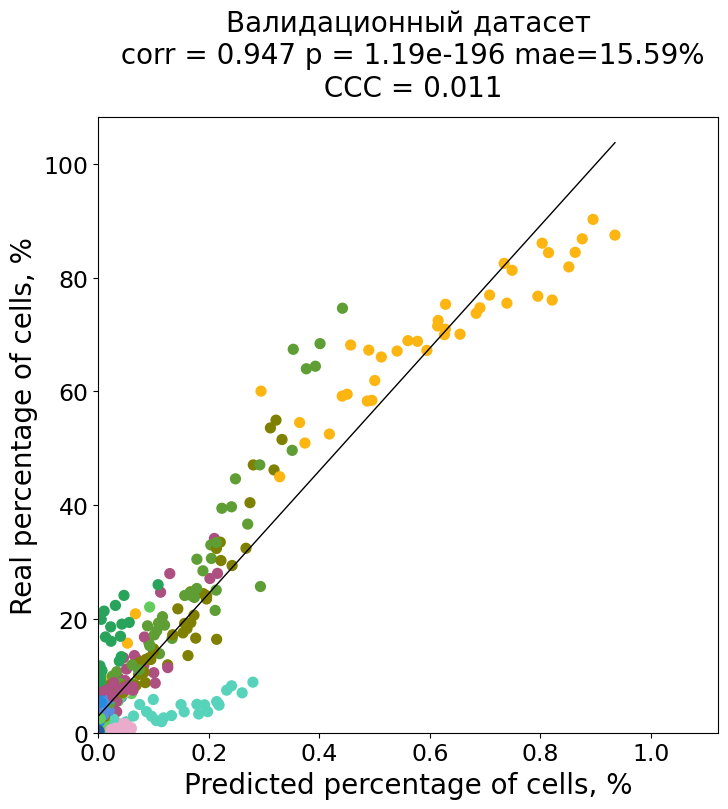

In [93]:
x = print_all_cells_in_one(final_predictions_trans, 
                           cytof,
                           pallete=cells_p,
                           title='Валидационный датасет', min_xlim=0, min_ylim=0)

# plt.savefig("all_transformers_results.png", dpi=1200, bbox_inches='tight', transparent=False)

# ConvNeXt VS transformers B_cells

In [117]:
selected_cell = 'B_cells'
onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'

selected_genes = cell_types[selected_cell].genes.copy()
if selected_cell != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])    


val_genes = selected_genes
val_expr = expr.loc[selected_genes]
val_expr = renorm_expressions(val_expr, genes_in_expression_file)
X_test = torch.tensor(val_expr.T.values, dtype=torch.float32)
dummy_data, dummy_target = mixer_test.generate(selected_cell,
                                   selected_genes,
                                   random_seed=17)
indeces = dummy_target.index.copy()
dummy_input = X_test 

try:
    onnx_model = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model)
    
    ort_session = ort.InferenceSession(onnx_model_path)
except Exception as e:
    print(f"Ошибка при загрузке модели для {selected_cell}: {e}")


all_outputs = []

for i in range(dummy_input.shape[0]):
    single_sample = dummy_input[i:i+1]  # shape: [1, input_dim]

    outputs = ort_session.run(
        None,
        {'bulk_normalized_vector': single_sample.numpy()}
    )[0]

    all_outputs.append(outputs)

outputs = np.vstack(all_outputs) 

predictions_B_cells = np.exp(outputs.T)*100


df_pred = pd.DataFrame(predictions, index=indeces, columns=expr.columns)
# adjusted_preds_trans_B_cells = adjust_rna_fractions(df_pred.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)
# final_predictions_trans_B_cells = convert_rna_to_cells_fractions(adjusted_preds_trans_B_cells, "./configs/cell_types.yaml", other_coeff=1.0)
# final_predictions_trans_B_cells*100
df_pred

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0627,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462
NK_cells,1.043123,3.887371,1.466305,4.229793,2.300562,7.179405,2.177861,1.599516,2.923810,4.154987,...,1.081562,1.775346,1.091627,0.676632,1.847470,0.306528,1.444133,0.990098,1.240058,0.519690
Monocytic_cells,7.782403,5.899153,9.039536,8.608707,14.418182,16.188164,24.714708,38.785286,41.463779,43.493050,...,3.251418,16.181841,7.281637,1.980986,3.047913,14.278087,13.975324,6.906299,8.324996,8.665425
T_cells,10.281706,24.182188,7.482496,19.144218,9.123014,25.597517,4.706742,40.285610,24.254280,29.273882,...,28.284267,10.678303,1.373508,10.312117,12.198880,17.920990,17.236197,30.394484,29.402287,23.626457
Granulocytes,23.842388,24.867617,25.974031,19.944334,24.399000,13.034436,31.835266,0.434299,0.408668,0.234166,...,26.470808,28.280916,39.308872,45.504128,33.724747,25.262285,25.629900,16.939083,18.343843,31.476768
Dendritic_cells,20.683739,14.956345,21.637375,17.237988,24.521212,17.128410,8.317180,6.558946,16.309761,1.534071,...,33.015350,21.372242,18.048565,22.870289,27.600349,9.723742,11.361756,22.345610,30.581141,12.945447
Endothelium,1.741357,0.752460,1.964561,1.236930,2.245658,0.930099,0.313299,0.433772,1.351042,0.658946,...,0.555301,0.310417,0.421762,1.251697,1.384472,1.251778,0.433948,1.190647,0.560377,0.714724
Fibroblasts,0.640156,1.121529,0.644686,1.092578,0.736938,1.260898,0.521634,0.538640,0.599329,0.725651,...,0.497507,0.663833,0.583246,0.950680,0.662198,1.190370,1.207906,1.055397,0.526609,1.378621
B_cells,0.586131,1.203631,0.464610,1.571707,0.428086,2.296133,0.399718,5.278473,4.668578,7.573499,...,1.515107,2.457733,0.093636,0.206454,0.323614,1.213296,1.336509,2.553415,1.280197,1.076722
Tumor,30.801842,22.590605,28.754780,25.823757,19.950382,16.548147,24.258755,6.935578,8.063368,11.803160,...,5.319728,15.884501,29.658905,15.728815,17.169531,29.867390,24.424702,18.708740,9.445646,19.055412


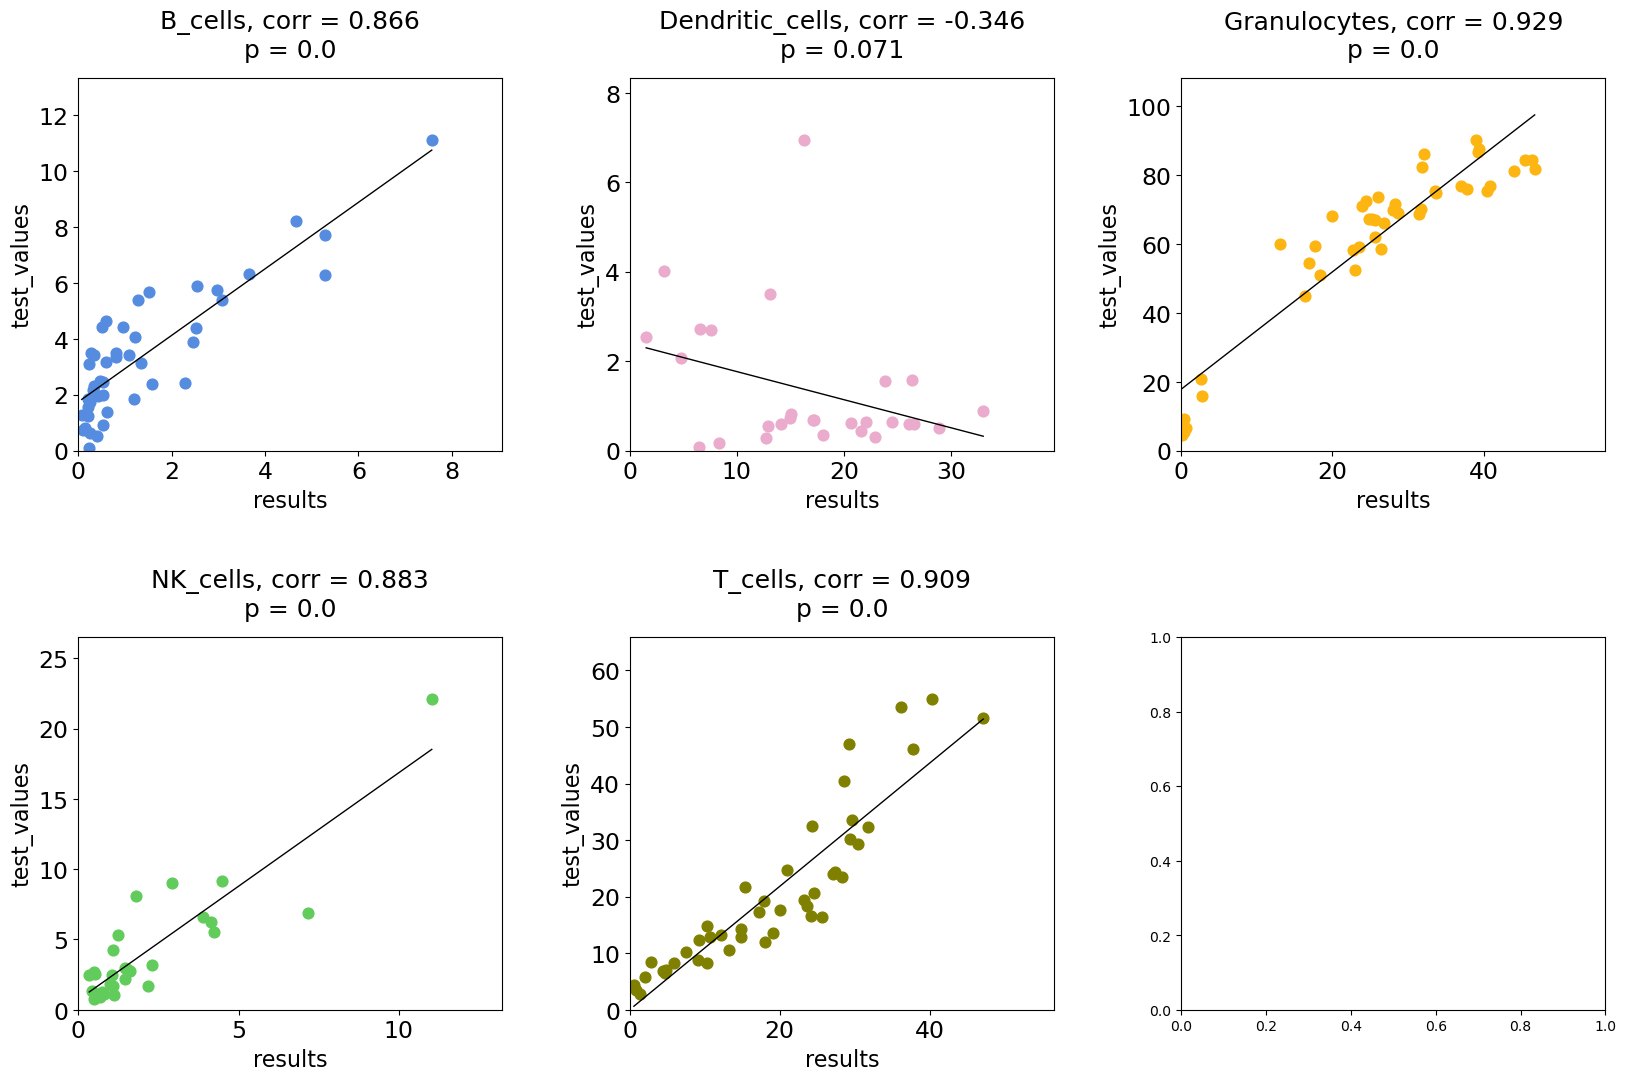

In [120]:
x = print_cell_matras(df_pred, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)
plt.savefig('B_cells_trans.jpg', dpi=600,  bbox_inches='tight', transparent=False)

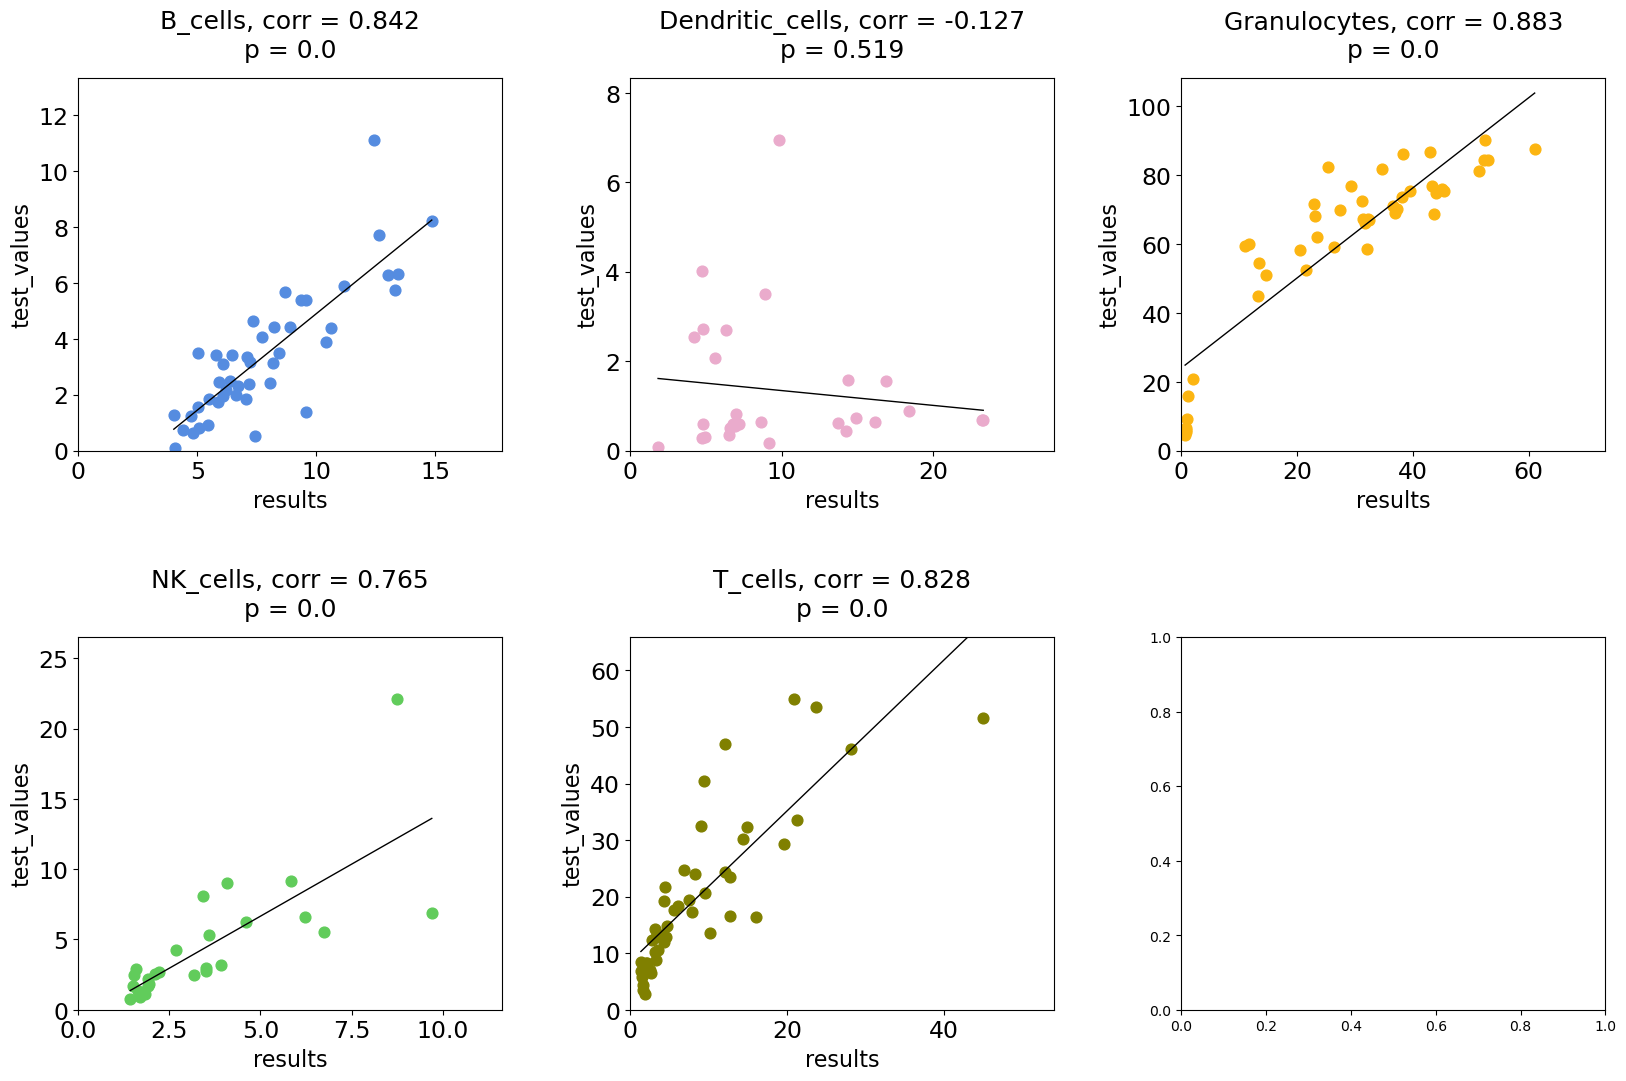

In [121]:
x = print_cell_matras(validation, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

plt.savefig('B_cells_convnext.jpg', dpi=600,  bbox_inches='tight', transparent=False)